# LOAD VÀ TẢI, IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [ ]:
pip install statsmodels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
import re
from datetime import datetime
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
sns.set(context='notebook')
sns.set_style("whitegrid", {'axes.grid' : False})
plt.tight_layout()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
#pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

<Figure size 640x480 with 0 Axes>

In [ ]:
# Tải các resource cần thiết từ NLTK
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
except:
    print("Lỗi khi tải NLTK resources, nhưng vẫn tiếp tục thực hiện")

# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_drug = pd.read_csv('drug_review_train.csv')

In [ ]:
df_drug.shape

(110811, 9)

In [ ]:
df_drug = df_drug.drop(columns=['Unnamed: 0'])

In [ ]:
df_drug.head(5)

patient_id       drugName                   condition  \
0       89879   Cyclosporine  keratoconjunctivitis sicca   
1      143975   Etonogestrel               birth control   
2      106473       Implanon               birth control   
3      184526    Hydroxyzine                     anxiety   
4       91587  Dalfampridine          multiple sclerosis   

                                              review  rating            date  \
0  "i have used restasis for about a year now and...     2.0  April 20, 2013   
1  "my experience has been somewhat mixed. i have...     7.0  August 7, 2016   
2  "this is my second implanon would not recommen...     1.0    May 11, 2016   
3  "i recommend taking as prescribed, and the bot...    10.0  March 19, 2012   
4  "i have been on ampyra for 5 days and have bee...     9.0  August 1, 2010   

   usefulCount  review_length  
0           69            147  
1            4            136  
2            6            140  
3          124            104  
4          101             74

In [ ]:
df_drug.columns

Index(['patient_id', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'review_length'],
      dtype='object')

In [ ]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110811 entries, 0 to 110810
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   patient_id     110811 non-null  int64  
 1   drugName       110811 non-null  object 
 2   condition      110811 non-null  object 
 3   review         110811 non-null  object 
 4   rating         110811 non-null  float64
 5   date           110811 non-null  object 
 6   usefulCount    110811 non-null  int64  
 7   review_length  110811 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 6.8+ MB


In [ ]:
df_drug.drop_duplicates(inplace=True)

In [ ]:
# Kiểm tra các giá trị null
missing_values = df_drug.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


### Xử lý các dòng lỗi

In [ ]:
# Lọc ra các dòng có chứa '</span>' trong cột 'condition'
filtered_conditions = df_drug[df_drug['condition'].str.contains('</span>', na=False)]


# In ra các chỉ mục và giá trị cột 'condition'
print(filtered_conditions[['condition']])

                                           condition
153       4</span> users found this comment helpful.
263       3</span> users found this comment helpful.
1170      7</span> users found this comment helpful.
1347      2</span> users found this comment helpful.
1350      1</span> users found this comment helpful.
1515      3</span> users found this comment helpful.
1920      0</span> users found this comment helpful.
2197      2</span> users found this comment helpful.
2449     13</span> users found this comment helpful.
3405      9</span> users found this comment helpful.
3437      2</span> users found this comment helpful.
3803      0</span> users found this comment helpful.
3915      1</span> users found this comment helpful.
4192      9</span> users found this comment helpful.
4198      3</span> users found this comment helpful.
4243      3</span> users found this comment helpful.
4306      0</span> users found this comment helpful.
4385      0</span> users found this comment he

=> Những dòng này dữ liệu HTML chưa dọn sạch nên trong bước preprocessing cần xử lý nó

In [ ]:
# Xóa tất cả các thẻ HTML kiểu </span> trong cột 'condition'
df_drug['condition'] = df_drug['condition'].str.replace('</span>', '', regex=False)
df_drug['condition'] = df_drug['condition'].str.strip()

# OVERVIEW

## Thống kê mô tả tổng quát

In [ ]:
# Kiểm tra số lượng review và dữ liệu duy nhất
print(f"Tổng số review: {df_drug.shape[0]}")
print(f"Số lượng thuốc khác nhau: {df_drug['drugName'].nunique()}")
print(f"Số lượng tình trạng bệnh khác nhau: {df_drug['condition'].nunique()}")

Tổng số review: 110811
Số lượng thuốc khác nhau: 2865
Số lượng tình trạng bệnh khác nhau: 791


In [ ]:
df_drug.describe(include='all')

patient_id        drugName      condition  \
count   110811.000000          110811         110811   
unique            NaN            2865            791   
top               NaN  Levonorgestrel  birth control   
freq              NaN            2833          22123   
mean    116008.545000             NaN            NaN   
std      66948.798417             NaN            NaN   
min          4.000000             NaN            NaN   
25%      58505.500000             NaN            NaN   
50%     116081.000000             NaN            NaN   
75%     173309.000000             NaN            NaN   
max     232289.000000             NaN            NaN   

                                                   review         rating  \
count                                              110811  110811.000000   
unique                                              84138            NaN   
top     "hi everyone, \r\r\ni am a 22 yr old female an...            NaN   
freq                                                    4            NaN   
mean                                                  NaN       7.007617   
std                                                   NaN       3.241435   
min                                                   NaN       1.000000   
25%                                                   NaN       5.000000   
50%                                                   NaN       8.000000   
75%                                                   NaN      10.000000   
max                                                   NaN      10.000000   

                 date    usefulCount  review_length  
count          110811  110811.000000  110811.000000  
unique           3577            NaN            NaN  
top     March 1, 2016            NaN            NaN  
freq              115            NaN            NaN  
mean              NaN      28.466470      95.475413  
std               NaN      37.620018      38.784644  
min               NaN       0.000000      31.000000  
25%               NaN       6.000000      63.000000  
50%               NaN      16.000000      95.000000  
75%               NaN      37.000000     130.000000  
max               NaN    1291.000000    1894.000000

## Phân tích phân phối và outlier, chỉ số Polarity


### Chỉ số Polarity là gì?
Chỉ số polarity là một thước đo trong phân tích tình cảm (sentiment analysis) để xác định mức độ tích cực hoặc tiêu cực của một văn bản. Cụ thể:

Polarity thường được biểu diễn trong khoảng từ -1 đến 1:

- Giá trị gần 1: văn bản mang tính tích cực  
0.1 < Polarity ≤ 0.5: Review hơi tích cực  
- Giá trị gần 0: văn bản trung tính  
-0.1 < Polarity ≤ 0.1: Review trung tính  
- Giá trị gần -1: văn bản mang tính tiêu cực  
Polarity ≤ -0.5: Review rất tiêu cực, thường chứa nhiều từ tiêu cực như "terrible", "awful", "horrible"

In [ ]:
# Tiền xử lý text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ các ký tự đặc biệt
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Loại bỏ stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
# Áp dụng tiền xử lý cho cột review
df_drug['processed_review'] = df_drug['review'].apply(preprocess_text)

# Tính polarity cho mỗi review
def get_polarity(text):
    if not text:
        return 0
    return TextBlob(text).sentiment.polarity

df_drug['polarity'] = df_drug['processed_review'].apply(get_polarity)

In [ ]:
df_drug['polarity']

0        -0.051667
1         0.094646
2         0.191667
3         0.152778
4         0.296853
            ...   
110806    0.254442
110807    0.160667
110808    0.206250
110809    0.000000
110810   -0.029167
Name: polarity, Length: 110811, dtype: float64

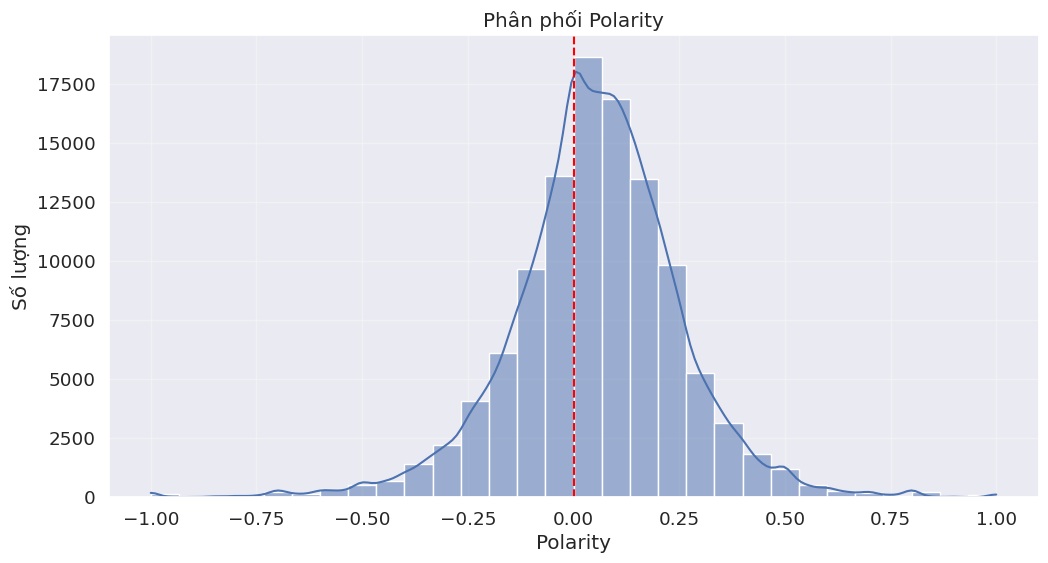

In [ ]:
# Kiểm tra phân phối của polarity
plt.figure(figsize=(12, 6))
sns.histplot(data=df_drug, x='polarity', bins=30, kde=True)
plt.title('Phân phối Polarity')
plt.xlabel('Polarity')
plt.ylabel('Số lượng')
plt.grid(True, alpha=0.3)
plt.axvline(0, color='red', linestyle='--')  # Đường phân cách giữa tích cực và tiêu cực
plt.show()

Từ biểu đồ hình chuông, có thể thấy hầu hết chỉ số tập trung xung quanh giá trị 0, tức là các bình luận (review) thường mang tính trung lập, hoặc ít cảm xúc ( hoặc bao gồm cả 2 tính ). Tuy nhiên, nhìn chung dữ liệu nghiêng nhẹ về phía tích cực, thể hiện qua diện tích phân phối bên phải đường đỏ đứt (tại giá trị 0) dường như lớn hơn một chút so với bên trái.

In [ ]:
# Thêm cột đánh giá trạng thái tình cảm
df_drug['sentiment_category'] = pd.cut(
    df_drug['polarity'],
    bins=[-1, -0.5, -0.1, 0.1, 0.5, 1],
    labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
)

In [ ]:
# Kiểm tra phân phối các loại sentiment
sentiment_counts = df_drug['sentiment_category'].value_counts()
print("Phân phối sentiment trong dataset:")
print(sentiment_counts)
print(f"Phần trăm: {sentiment_counts / len(df_drug) * 100}")

Phân phối sentiment trong dataset:
sentiment_category
Neutral               46616
Positive              42322
Negative              18978
Extremely Positive     1567
Extremely Negative     1190
Name: count, dtype: int64
Phần trăm: sentiment_category
Neutral               42.068026
Positive              38.192959
Negative              17.126459
Extremely Positive     1.414120
Extremely Negative     1.073901
Name: count, dtype: float64


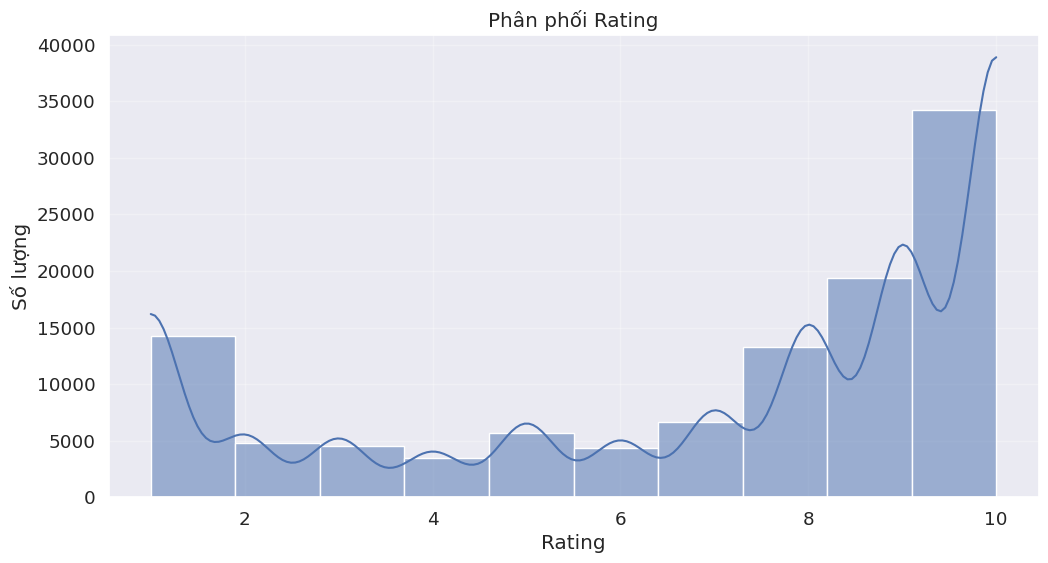

In [ ]:
# Phân phối Rating
plt.figure(figsize=(12, 6))
sns.histplot(data=df_drug, x='rating', bins=10, kde=True)
plt.title('Phân phối Rating')
plt.xlabel('Rating')
plt.ylabel('Số lượng')
plt.grid(True, alpha=0.3)
plt.show()

Phân phối của 'rating' làm rõ xu hướng cảm xúc của bệnh nhân khi chỉ số từ 7 trở lên (tích cực) có ưu thế hơn, trong đó rating 9,10 có số lượng cao nhất trong tổng số.

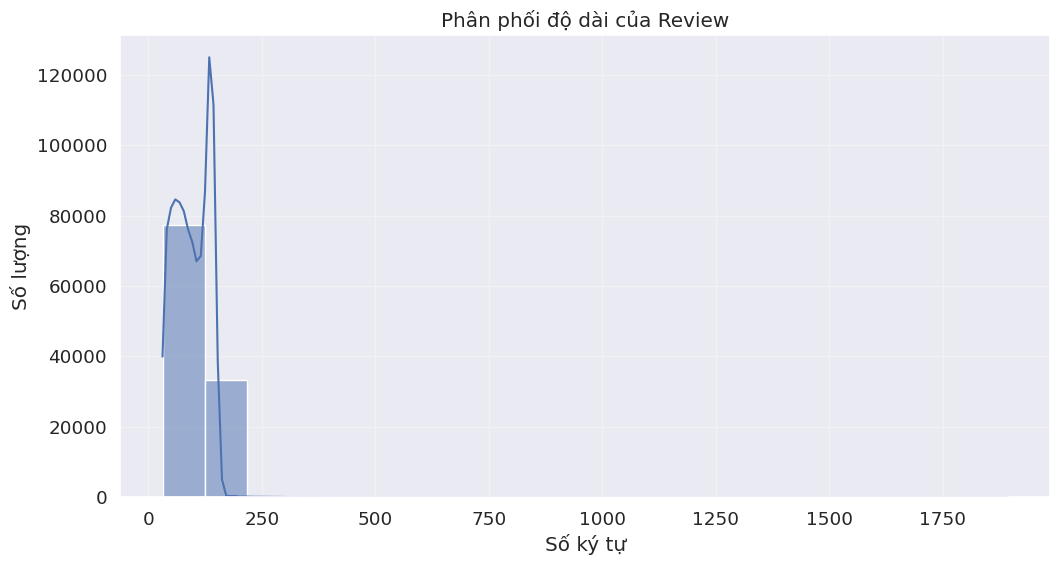

In [ ]:
# Phân phối độ dài của review
plt.figure(figsize=(12, 6))
sns.histplot(data=df_drug, x='review_length', bins=20, kde=True)
plt.title('Phân phối độ dài của Review')
plt.xlabel('Số ký tự')
plt.ylabel('Số lượng')
plt.grid(True, alpha=0.3)
plt.show()

Hầu hết bệnh nhân có xu hướng viết review ngắn gọn, đơn giản từ ( 0 - 200 ) kí tự, phần lớn là từ 50 - 200 kí tự, có một đỉnh cao nhất ở khoảng 150 ký tự với số lượng review đạt xấp xỉ 125,000.

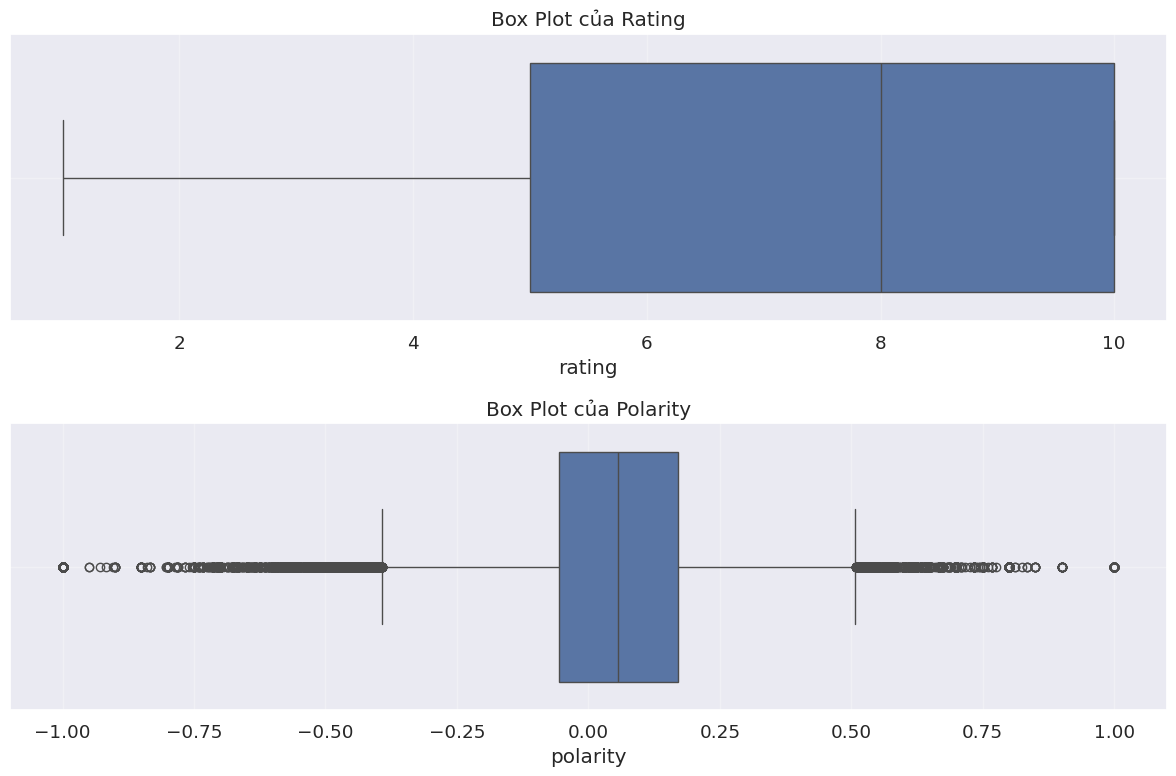

In [ ]:
# Outlier Analysis với Box Plot
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.boxplot(x=df_drug['rating'])
plt.title('Box Plot của Rating')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
sns.boxplot(x=df_drug['polarity'])
plt.title('Box Plot của Polarity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Trong khi đánh giá của **rating** khá cao (trung vị khoảng 8 là khá cao), phân phối cho thấy người dùng đánh giá khá cao khi IQR từ 6-10, gần như không có outlier; nhưng trong phân phối **polarity** trung vị chỉ dao động hơn 0 một chút, IQR từ (-0.1 - 0.25) cho thấy dữ liệu từ bình luận khá trung tính từ hơi tiêu cực đến hơi tích cực.  
**Nhận xét chung**  
- Có sự không đồng nhất giữa Rating và Polarity: Mặc dù đa số rating cao (6-10), nhưng phân tích cảm xúc (polarity) phần lớn nằm gần giá trị 0, chỉ hơi nghiêng về phía tích cực.
- Điều này có thể cho thấy rằng dù người dùng đánh giá cao về mặt số điểm, ngôn ngữ họ sử dụng trong review không nhất thiết thể hiện cảm xúc tích cực mạnh tương ứng.
- Các đánh giá có độ lệch mạnh về polarity (rất tích cực hoặc rất tiêu cực) đều được xem là ngoại lai, trong khi rating cao lại là phổ biến.

In [ ]:
# Z-score để tìm outlier của polarity
from scipy import stats
z_scores = stats.zscore(df_drug['polarity'])
outliers = (abs(z_scores) > 3)
print(f"Số lượng outlier trong polarity: {outliers.sum()}")
print(f"Phần trăm outlier: {outliers.sum() / len(df_drug) * 100:.2f}%")

Số lượng outlier trong polarity: 1458
Phần trăm outlier: 1.32%


## Phân tích tương quan

In [ ]:
# Tương quan giữa Polarity và Rating
correlation = df_drug['polarity'].corr(df_drug['rating'])
print(f"Hệ số tương quan Pearson giữa Polarity và Rating: {correlation:.4f}")

Hệ số tương quan Pearson giữa Polarity và Rating: 0.3267


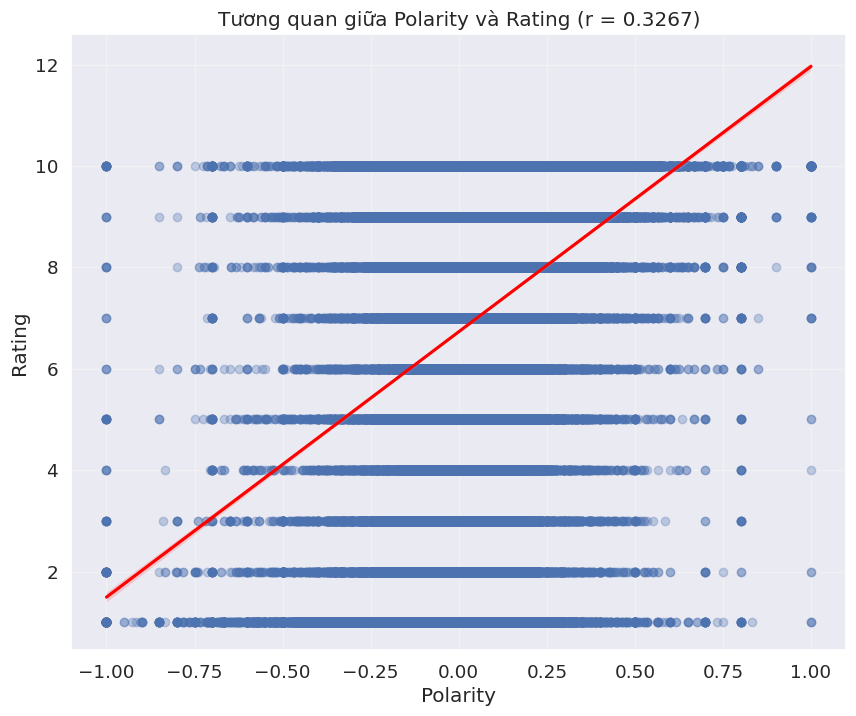

In [ ]:
# Vẽ Scatter plot với regression line
plt.figure(figsize=(10, 8))
sns.regplot(x='polarity', y='rating', data=df_drug, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title(f'Tương quan giữa Polarity và Rating (r = {correlation:.4f})')
plt.xlabel('Polarity')
plt.ylabel('Rating')
plt.grid(True, alpha=0.3)
plt.show()

Hệ số tương quan r = 0.3267 thể hiện mối tương quan dương yếu đến trung bình giữa polarity và rating. Điều này có nghĩa là khi polarity tăng (review có nội dung tích cực hơn), rating có xu hướng tăng nhẹ, nhưng mối liên hệ không mạnh.

Ở mỗi mức rating, polarity có sự phân tán rất lớn, trải dài từ -1 đến +1. Điều này chỉ ra rằng cùng một mức đánh giá (rating) có thể được thể hiện bằng ngôn ngữ có cảm xúc khác nhau rất nhiều.

Đặc biệt, thậm chí ở các mức rating cao (8-10), vẫn có những review có polarity âm (ngôn ngữ tiêu cực), điều này khá bất thường và có thể do:

- Người dùng viết nhận xét tiêu cực nhưng vẫn đánh giá cao, hoặc người dùng có cả đánh giá tiêu cực và tích cực trong bình luận.
- Có vấn đề trong thuật toán phân tích cảm xúc
- Bệnh nhân không thích và mỉa mai sản phẩm nhưng khó phát hiện bằng tính toán.

Đường hồi quy tuyến tính (đường đỏ) có độ dốc dương, phản ánh mối tương quan dương giữa hai biến, nhưng độ dốc không quá lớn do tương quan yếu.


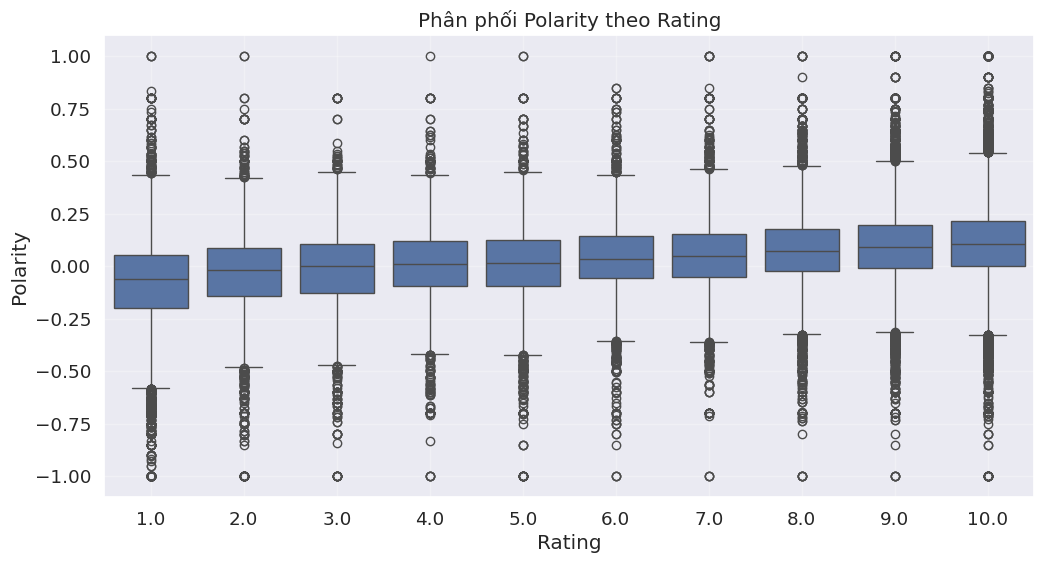

In [ ]:
# Polarity theo Rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='rating', y='polarity', data=df_drug)
plt.title('Phân phối Polarity theo Rating')
plt.xlabel('Rating')
plt.ylabel('Polarity')
plt.grid(True, alpha=0.3)
plt.show()

Dễ thấy nhất là **rating** có xu hướng tăng dần, và gom cụm:
- Với các mức Rating cao (8.0-10.0), phân phối có xu hướng dịch chuyển rõ hơn về phía giá trị Polarity dương.
- Trong khi ở các mức Rating thấp (1.0-3.0), phân phối nghiêng về phía giá trị Polarity âm.

Mặc dù có mối tương quan dương giữa Rating và Polarity, vẫn tồn tại nhiều trường hợp ngoại lệ (outliers) với Rating cao nhưng Polarity âm và ngược lại. Điều này có thể do nhiều yếu tố như đã bình luận ở biểu đồ tương quan giữa rating và polarity.

In [ ]:
# Bảng crosstab giữa sentiment_category và rating (đã nhóm)
df_drug['rating_group'] = pd.cut(df_drug['rating'], bins=[0, 4, 7, 10], labels=['Negative (1-4)', 'Neutral (5-7)', 'Positive (8-10)'])
sentiment_rating_cross = pd.crosstab(df_drug['sentiment_category'], df_drug['rating_group'], normalize='index') * 100
print("Phần trăm phân bố rating theo nhóm sentiment:")
print(sentiment_rating_cross)

Phần trăm phân bố rating theo nhóm sentiment:
rating_group        Negative (1-4)  Neutral (5-7)  Positive (8-10)
sentiment_category                                                
Extremely Negative       67.731092      11.680672        20.588235
Negative                 46.327326      16.224049        37.448625
Neutral                  25.045049      16.788227        58.166724
Positive                 13.236615      13.047588        73.715798
Extremely Positive        8.487556      10.019145        81.493299


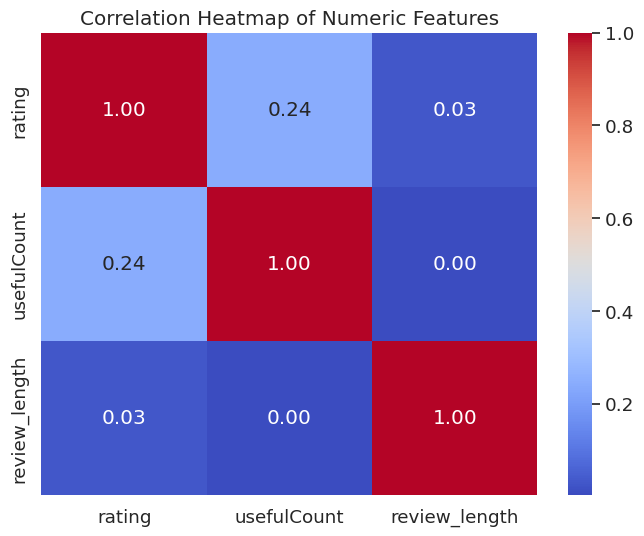

In [ ]:
# Select numerical columns
numeric_cols = ['rating', 'usefulCount', 'review_length']

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_drug[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


- rating vs usefulCount có thể giữ lại dù tương quan không cao (0.24)  
- usefulCount vs review_length = 0, rating vs review_length = 0.0  => Xem xét để Drop review_length vì biểu đồ cho thấy: độ dài của review không ảnh hưởng đến việc nó được đánh giá là hữu ích hay không.

## Phân tích xu hướng theo thời gian

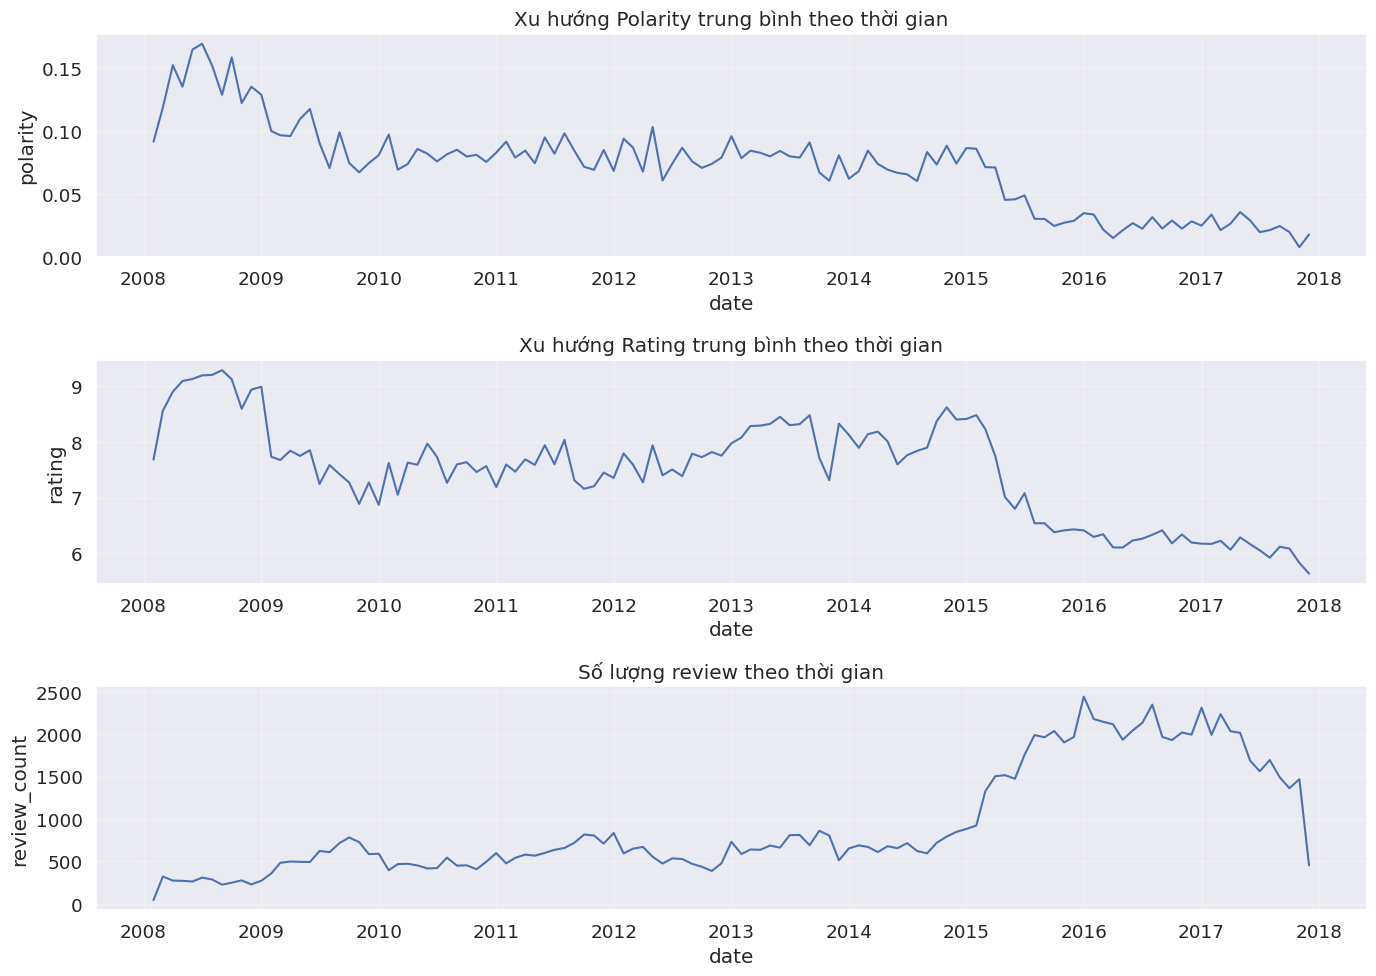

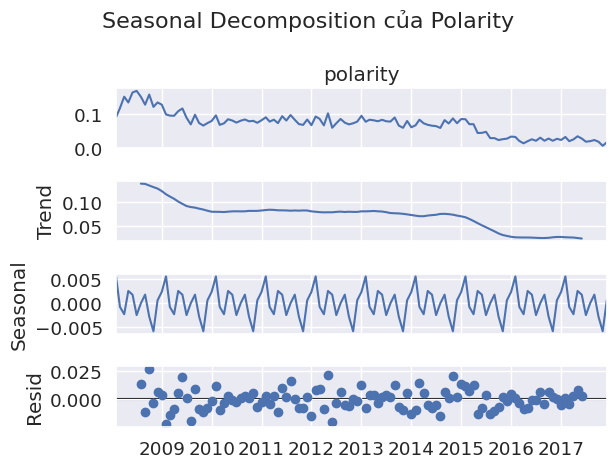

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Chuyển đổi date thành datetime (nếu có cột date)
if 'date' in df_drug.columns:
    df_drug['date'] = pd.to_datetime(df_drug['date'])
    df_drug['year'] = df_drug['date'].dt.year
    df_drug['month'] = df_drug['date'].dt.month

    # Phân tích xu hướng polarity theo thời gian
    time_trend = df_drug.groupby(['year', 'month']).agg({
        'polarity': 'mean',
        'rating': 'mean',
        'drugName': 'count'
    }).reset_index()
    time_trend.rename(columns={'drugName': 'review_count'}, inplace=True)

    # Tạo cột datetime
    time_trend['date'] = pd.to_datetime(time_trend[['year', 'month']].assign(day=1))
    time_trend.set_index('date', inplace=True)  # Quan trọng để phân tích time series

    # Biểu đồ xu hướng theo thời gian
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    sns.lineplot(x=time_trend.index, y='polarity', data=time_trend)
    plt.title('Xu hướng Polarity trung bình theo thời gian')
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 1, 2)
    sns.lineplot(x=time_trend.index, y='rating', data=time_trend)
    plt.title('Xu hướng Rating trung bình theo thời gian')
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 1, 3)
    sns.lineplot(x=time_trend.index, y='review_count', data=time_trend)
    plt.title('Số lượng review theo thời gian')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ============================
    # Phân tích Seasonality & Trend cho 'polarity'
    # ============================
    result = seasonal_decompose(time_trend['polarity'], model='additive', period=12)

    # Vẽ kết quả phân tích
    result.plot()
    plt.suptitle("Seasonal Decomposition của Polarity", fontsize=16)
    plt.tight_layout()
    plt.show()


- Polarity của review có xu hướng giảm dần theo thời gian, đặc biệt rõ rệt từ sau năm 2015.  
- Tồn tại yếu tố chu kỳ trong dữ liệu, mặc dù ảnh hưởng không lớn.
Phần lớn biến động của polarity được giải thích bởi xu hướng dài hạn giảm dần, hơn là yếu tố mùa vụ.  
- Giai đoạn 2015-2017 có sự tăng đột biến về số lượng review, nhưng lại đi kèm với sự sụt giảm về chất lượng đánh giá (polarity và rating thấp hơn).
- Điều này có thể phản ánh người dùng ngày càng có xu hướng bày tỏ cảm xúc tiêu cực hơn trong review, hoặc có thể do sự thay đổi trong sản phẩm/dịch vụ được đánh giá theo thời gian.

## Phân tích Top 10/20

In [ ]:
# Top 20 từ phổ biến nhất trong reviews
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def get_top_words(text_series, n=20):
    stop_words = set(stopwords.words('english'))
    words = []
    for text in text_series:
        if isinstance(text, str):
            # Loại bỏ dấu câu và chuyển thành chữ thường
            text = text.lower().translate(str.maketrans('', '', string.punctuation))
            # Tách từ và loại bỏ stopwords
            words.extend([word for word in text.split() if word not in stop_words and len(word) > 2])
    return Counter(words).most_common(n)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


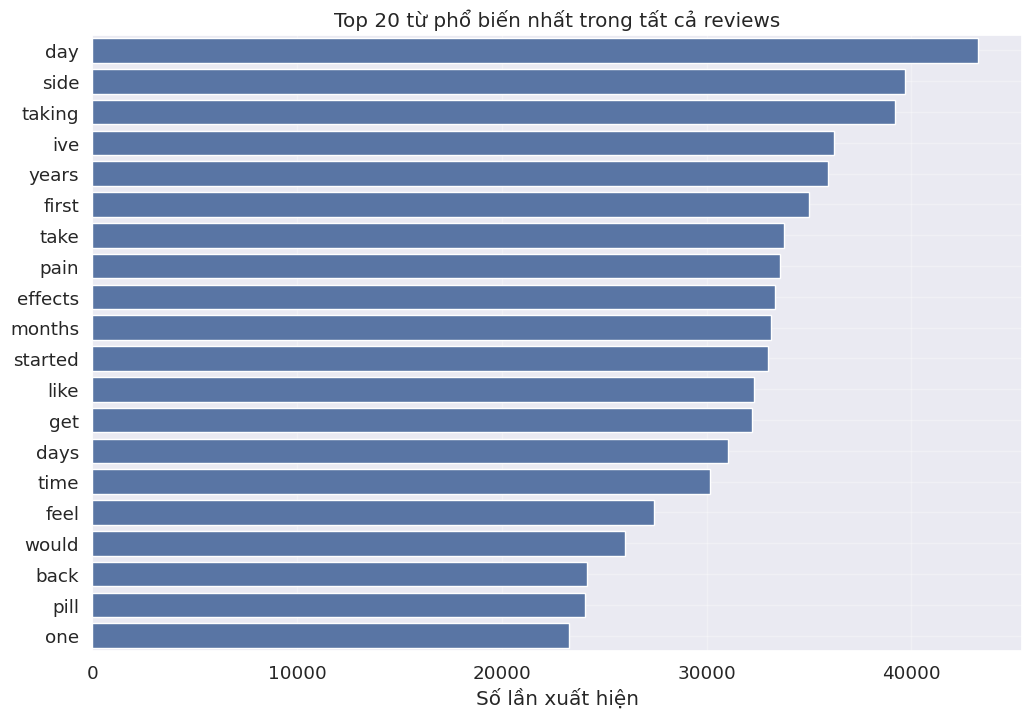

In [ ]:
# Top 20 từ phổ biến trong tất cả các review
top_words = get_top_words(df_drug['review'], 20)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('Top 20 từ phổ biến nhất trong tất cả reviews')
plt.xlabel('Số lần xuất hiện')
plt.grid(True, alpha=0.3)
plt.show()

- Các reviews rõ ràng tập trung vào thuốc và trải nghiệm điều trị, với từ khóa phổ biến liên quan đến thời gian sử dụng ("day", "months", "years"), quá trình dùng thuốc ("taking", "take", "pill") và phản ứng ("side", "pain", "effects").
Người dùng thường chia sẻ trải nghiệm cá nhân (từ "ive" xuất hiện nhiều) khi sử dụng thuốc, có thể để thông báo cho người khác về hiệu quả và tác dụng phụ.

- Sự sụt giảm về polarity (độ tích cực) và rating (điểm đánh giá) từ năm 2015 trở đi có thể phản ánh sự gia tăng của tác dụng phụ hoặc hiệu quả không như mong đợi.
Đáng chú ý là số lượng review tăng đột biến cùng thời điểm rating giảm - điều này có thể chỉ ra rằng khi người dùng gặp vấn đề với thuốc, họ có xu hướng viết đánh giá nhiều hơn.

- Từ "side" (có thể là một phần của "side effects" - tác dụng phụ) xuất hiện rất nhiều, cho thấy người dùng đặc biệt quan tâm đến các phản ứng không mong muốn của thuốc.
Từ "pain" xuất hiện với tần suất cao, gợi ý rằng nhiều thuốc được đánh giá có liên quan đến điều trị đau hoặc gây ra đau như một tác dụng phụ.

- Có thể đối tượng được đánh giá là một thuốc hoặc nhóm thuốc đã giảm hiệu quả hoặc có nhiều báo cáo về tác dụng phụ hơn theo thời gian.
Hoặc có thể đã có sự thay đổi trong công thức, liều lượng, hoặc hướng dẫn sử dụng của thuốc từ năm 2015 trở đi.

- Sự giảm xuống về số lượng review vào năm 2018 có thể do nhiều nguyên nhân: thuốc được thay thế bằng phương pháp điều trị mới, website đánh giá giảm phổ biến, hoặc người dùng chuyển sang nền tảng khác để thảo luận.

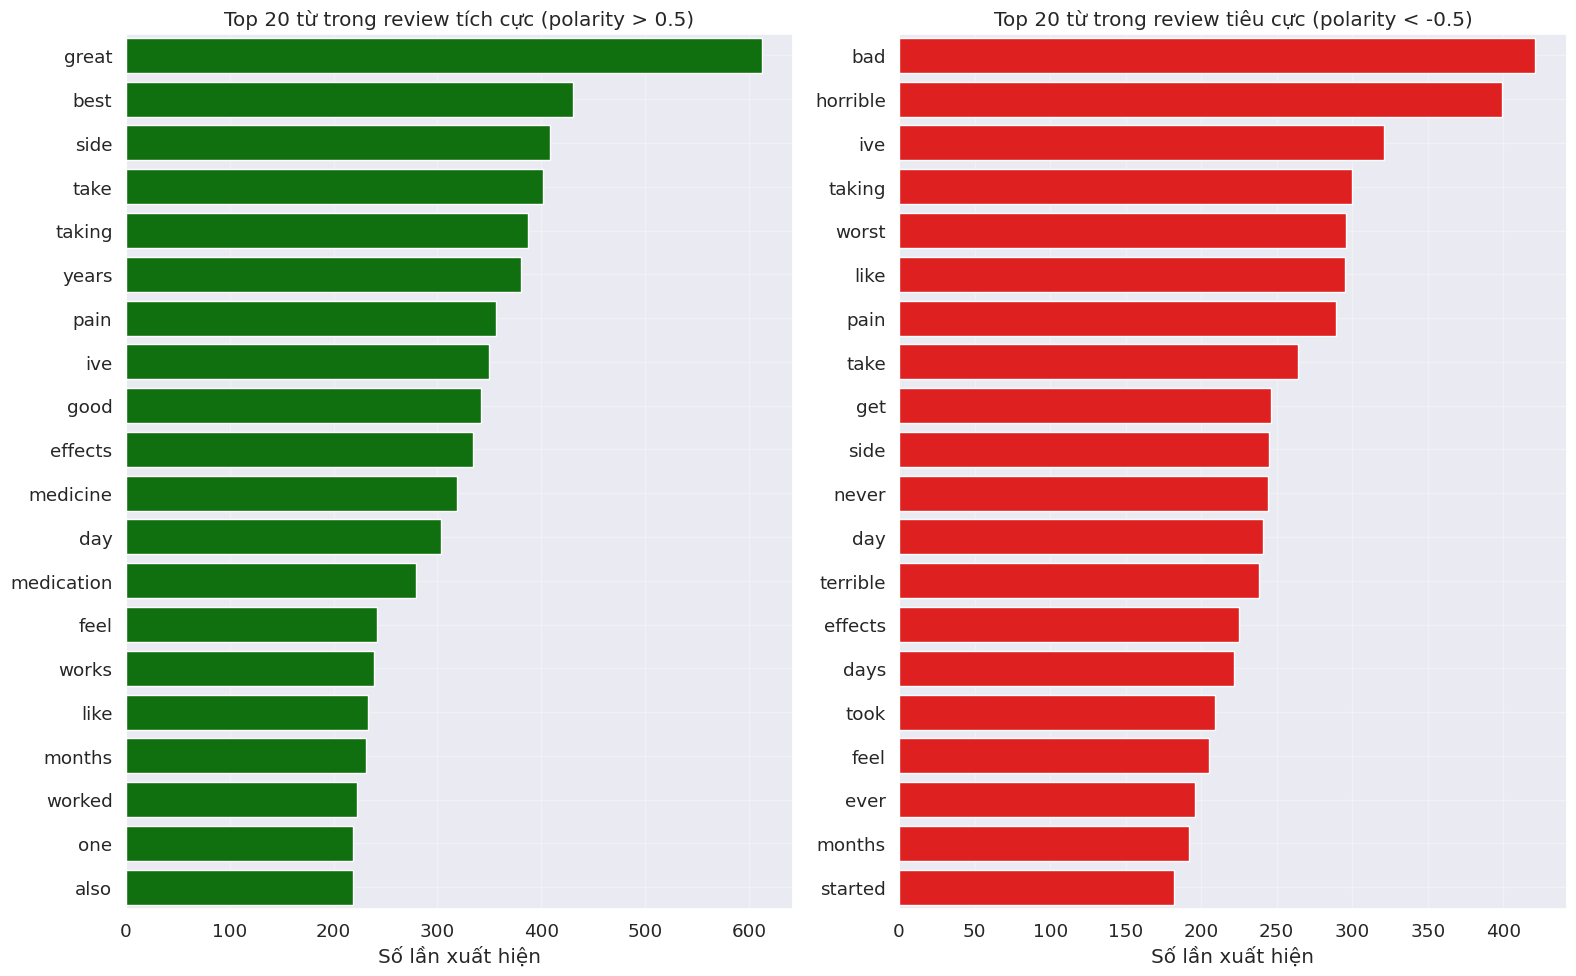

In [ ]:
# Top từ trong review tích cực và tiêu cực
positive_reviews = df_drug[df_drug['polarity'] > 0.5]['review']
negative_reviews = df_drug[df_drug['polarity'] < -0.5]['review']

top_positive_words = get_top_words(positive_reviews, 20)
pos_words, pos_counts = zip(*top_positive_words)

top_negative_words = get_top_words(negative_reviews, 20)
neg_words, neg_counts = zip(*top_negative_words)

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
sns.barplot(x=list(pos_counts), y=list(pos_words), color='green')
plt.title('Top 20 từ trong review tích cực (polarity > 0.5)')
plt.xlabel('Số lần xuất hiện')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.barplot(x=list(neg_counts), y=list(neg_words), color='red')
plt.title('Top 20 từ trong review tiêu cực (polarity < -0.5)')
plt.xlabel('Số lần xuất hiện')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Rõ ràng có 1 số từ được thể hiện rõ rệt như : great, best, good ( với positive) và bad, horrible, worst ( với negative) được chia rõ ràng nhưng cũng có 1 số từ đều xuất hiện ở hai trạng thái

- Các từ thể hiện hiệu quả rõ rệt: "great", "best", "good", "works", "worked"
Xuất hiện các từ liên quan đến thuốc: "medicine", "medication", "side", "effects"
Từ "pain" xuất hiện trong ngữ cảnh tích cực, có thể chỉ việc giảm đau thành công

- Từ ngữ tiêu cực mạnh mẽ: "bad", "horrible", "worst", "terrible", "never"
Từ "pain" cũng xuất hiện trong đánh giá tiêu cực, nhưng trong ngữ cảnh khác (có thể là thuốc không giảm đau hoặc gây đau)

- "side", "taking", "take", "pain", "ive", "day", "like", "effects", "feel", "months"
Điều này cho thấy cùng một chủ đề (tác dụng phụ, quá trình dùng thuốc, cảm giác đau) được đề cập trong cả hai loại đánh giá, nhưng với trải nghiệm khác nhau

- Tần suất từ trong đánh giá tích cực (trục x lên đến ~600) cao hơn so với đánh giá tiêu cực (trục x lên đến ~400)
Từ "great" trong đánh giá tích cực và "bad" trong đánh giá tiêu cực đều là từ xuất hiện nhiều nhất

- Đánh giá tích cực tập trung vào hiệu quả của thuốc ("works", "worked") và đánh giá chung ("great", "best", "good")
Đánh giá tiêu cực tập trung vào trải nghiệm không tốt ("bad", "horrible", "worst", "terrible") và sự thất vọng ("never")

- Kết hợp với biểu đồ trước:
Sự sụt giảm rating và polarity từ 2015 trở đi có thể giải thích bằng việc tăng tỷ lệ đánh giá tiêu cực.
Người dùng có thể gặp nhiều vấn đề với tác dụng phụ hoặc hiệu quả điều trị không như mong đợi.

# PHÂN TÍCH THEO TÊN THUỐC (DRUG NAME)

In [ ]:
# Số lượng review theo từng loại thuốc
drug_counts = df_drug['drugName'].value_counts()
print(f"Tổng số loại thuốc: {len(drug_counts)}")
print(f"Số thuốc chỉ có 1 review: {sum(drug_counts == 1)}")

Tổng số loại thuốc: 2865
Số thuốc chỉ có 1 review: 696


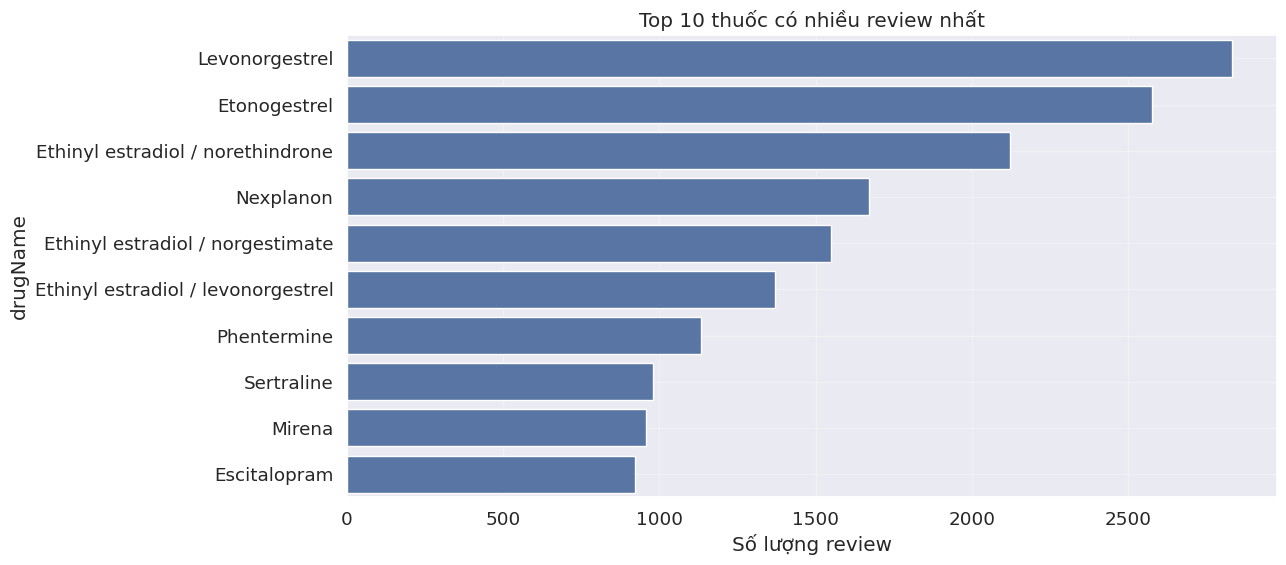

In [ ]:
# Top 10 thuốc có nhiều review nhất
top_drugs_by_count = df_drug['drugName'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_drugs_by_count.values, y=top_drugs_by_count.index)
plt.title('Top 10 thuốc có nhiều review nhất')
plt.xlabel('Số lượng review')
plt.grid(True, alpha=0.3)
plt.show()

- Thuốc tránh thai chiếm ưu thế:
6/10 loại thuốc trong danh sách là các thuốc tránh thai hoặc thuốc có chứa hormones: Levonorgestrel, Etonogestrel, các kết hợp Ethinyl estradiol (với norethindrone, norgestimate, levonorgestrel), và Mirena
Levonorgestrel đứng đầu danh sách với khoảng 2.700 review
Etonogestrel đứng thứ hai với khoảng 2.600 review


- Phân loại các loại thuốc:
Thuốc tránh thai/hormone: Levonorgestrel, Etonogestrel, Ethinyl estradiol (các kết hợp), Mirena
Thuốc chống trầm cảm/SSRI: Sertraline, Escitalopram
Thuốc giảm cân: Phentermine
Thuốc cấy tránh thai: Nexplanon (chứa etonogestrel)


- Việc xác định được các loại thuốc giải thích rõ hơn về những từ khóa phổ biến đã thấy trong biểu đồ trước như "side", "effects", "pain"
Các thuốc tránh thai thường có các tác dụng phụ được người dùng quan tâm báo cáo


- Có sự chênh lệch lớn về số lượng review giữa các loại thuốc đầu bảng và cuối bảng
Levonorgestrel và Etonogestrel có số lượng review cao nhất, gần gấp đôi so với các thuốc cuối bảng
Nhóm thuốc chống trầm cảm (Sertraline, Escitalopram) có số lượng review thấp hơn, khoảng 1.000 review.

Bộ dữ liệu có vẻ thiên về đối tượng sử dụng là phụ nữ, do phần lớn các thuốc được đánh giá liên quan đến sức khỏe sinh sản nữ
Các loại thuốc tâm thần (Sertraline, Escitalopram) và giảm cân (Phentermine) cũng xuất hiện trong top 10, cho thấy mối quan tâm về sức khỏe tâm thần và cân nặng.

##  Phân tích rating và polarity theo thuốc

In [ ]:
# Lọc ra các thuốc có ít nhất 30 review để đảm bảo độ tin cậy
min_reviews = 30
popular_drugs = drug_counts[drug_counts >= min_reviews].index.tolist()
popular_drugs_df = df_drug[df_drug['drugName'].isin(popular_drugs)]

# Tính rating trung bình và polarity trung bình cho mỗi loại thuốc
drug_stats = popular_drugs_df.groupby('drugName').agg({
    'rating': ['mean', 'median', 'std', 'count'],
    'polarity': ['mean', 'median', 'std']
}).reset_index()

drug_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in drug_stats.columns.values]

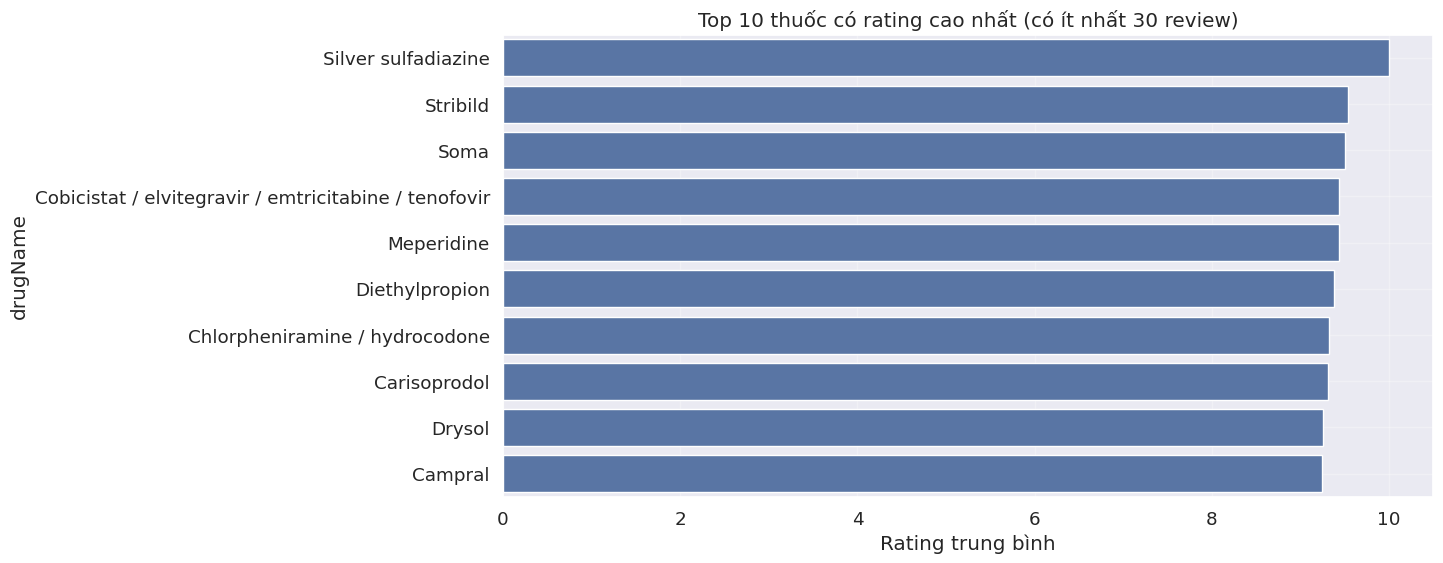

In [ ]:
# Top 10 thuốc có rating cao nhất
top_rated_drugs = drug_stats.sort_values('rating_mean', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='rating_mean', y='drugName', data=top_rated_drugs)
plt.title(f'Top 10 thuốc có rating cao nhất (có ít nhất {min_reviews} review)')
plt.xlabel('Rating trung bình')
plt.grid(True, alpha=0.3)
plt.show()

1. **Các thuốc có rating cao nhất:**
   - Silver sulfadiazine (kem kháng khuẩn điều trị bỏng) dẫn đầu với rating gần 10/10
   - Tất cả các thuốc trong danh sách đều có rating rất cao, từ 9.0 trở lên
   - Sự chênh lệch giữa các thuốc trong top 10 là không nhiều

2. **Đa dạng về nhóm thuốc:**
   - Thuốc kháng sinh/kháng khuẩn: Silver sulfadiazine
   - Thuốc kháng virus/HIV: Cobicistat/elvitegravir/emtricitabine/tenofovir (thuốc điều trị HIV)
   - Thuốc giảm đau/gây nghiện: Meperidine, Chlorpheniramine/hydrocodone
   - Thuốc an thần/chống co giật: Soma (carisoprodol)
   - Thuốc chống viêm: Drysol, Campral
   - Thuốc tim mạch: Carisoprodol

3. **So sánh với top thuốc có nhiều review nhất:**
   - Các thuốc trong danh sách này hoàn toàn khác với top 20 thuốc có nhiều review nhất
   - Không có thuốc tránh thai hoặc thuốc hormone nào trong top 10 này
   - Nhiều thuốc trong danh sách này thường được kê đơn cho các tình trạng y tế nghiêm trọng hoặc đau đớn

4. **Phân tích về rating cao:**
   - Các thuốc có rating cao thường là những thuốc có tác dụng rõ rệt, nhanh chóng giảm các triệu chứng hoặc cải thiện tình trạng bệnh
   - Một số thuốc giảm đau mạnh (như Meperidine, hydrocodone) thường được đánh giá cao vì khả năng kiểm soát cơn đau hiệu quả
   - Các thuốc điều trị HIV, bỏng và các bệnh nghiêm trọng khác có thể mang lại sự cải thiện đáng kể cho bệnh nhân

5. **Điểm đáng chú ý:**
   - Biểu đồ này chỉ xét các thuốc có ít nhất 30 reviews, loại bỏ các thuốc có quá ít đánh giá
   - Rating cao của các thuốc này cho thấy chúng đáp ứng tốt nhu cầu của người dùng, dù không phổ biến bằng các thuốc tránh thai hoặc thuốc tâm thần

Dữ liệu cho thấy mức độ phổ biến (số lượng review) không nhất thiết tương quan với mức độ hài lòng (rating). Nhiều thuốc dù không được đánh giá nhiều nhưng có hiệu quả rất cao đối với những bệnh nhân sử dụng chúng.

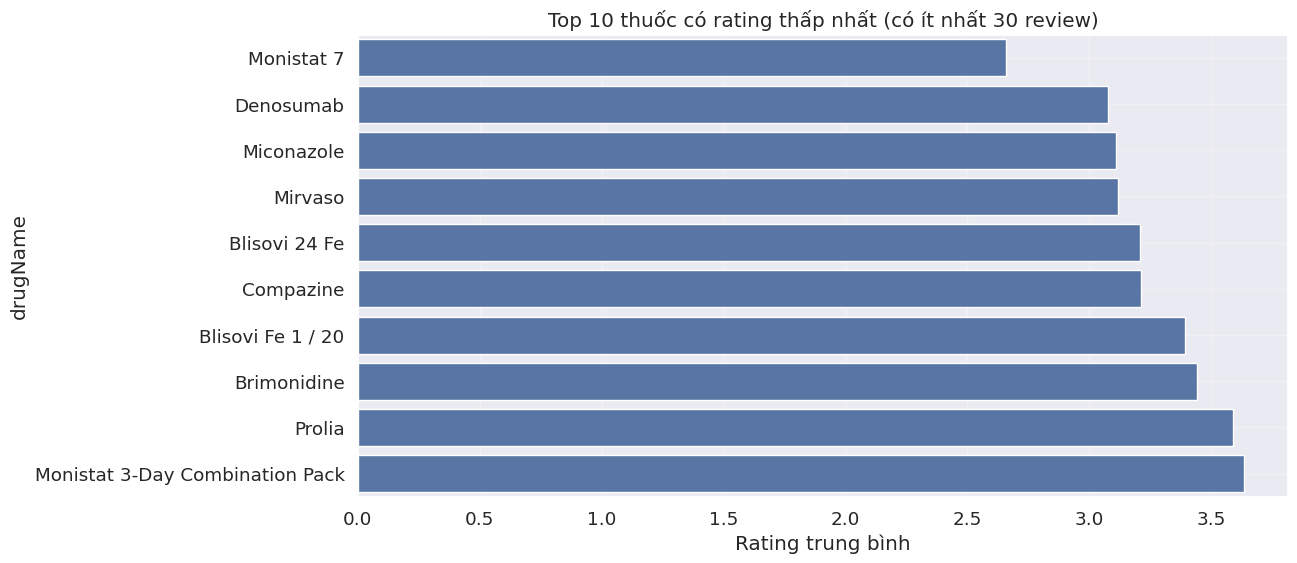

In [ ]:
# Top 10 thuốc có rating thấp nhất
lowest_rated_drugs = drug_stats.sort_values('rating_mean').head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='rating_mean', y='drugName', data=lowest_rated_drugs)
plt.title(f'Top 10 thuốc có rating thấp nhất (có ít nhất {min_reviews} review)')
plt.xlabel('Rating trung bình')
plt.grid(True, alpha=0.3)
plt.show()

Nhận xét chung:

- Có sự xuất hiện của một số nhóm thuốc cùng loại trong danh sách, như thuốc chống nấm (Monistat 7, Miconazole, Monistat 3-Day) và thuốc tránh thai (Blisovi 24 Fe, Blisovi Fe 1/20).
- Thang điểm đánh giá dường như là 3,5 điểm, không phải 5 điểm như thông thường. Điều này khiến khoảng cách giữa các rating không quá lớn.
Mặc dù nằm trong top 10 thuốc có rating thấp nhất, hầu hết các thuốc vẫn có điểm số trung bình trên 3,0/3,5, cho thấy người dùng vẫn đánh giá tương đối tích cực.
- Điều đáng chú ý là Monistat 7 (liệu trình 7 ngày) có điểm thấp hơn đáng kể so với Monistat 3-Day Combination Pack (liệu trình 3 ngày), điều này có thể phản ánh sự ưa thích của bệnh nhân đối với liệu trình điều trị ngắn hơn.
Các thuốc điều trị loãng xương (Denosumab, Prolia) có rating khá khác biệt mặc dù có cùng hoạt chất, điều này có thể liên quan đến cách thức đóng gói, thương hiệu hoặc giá cả.

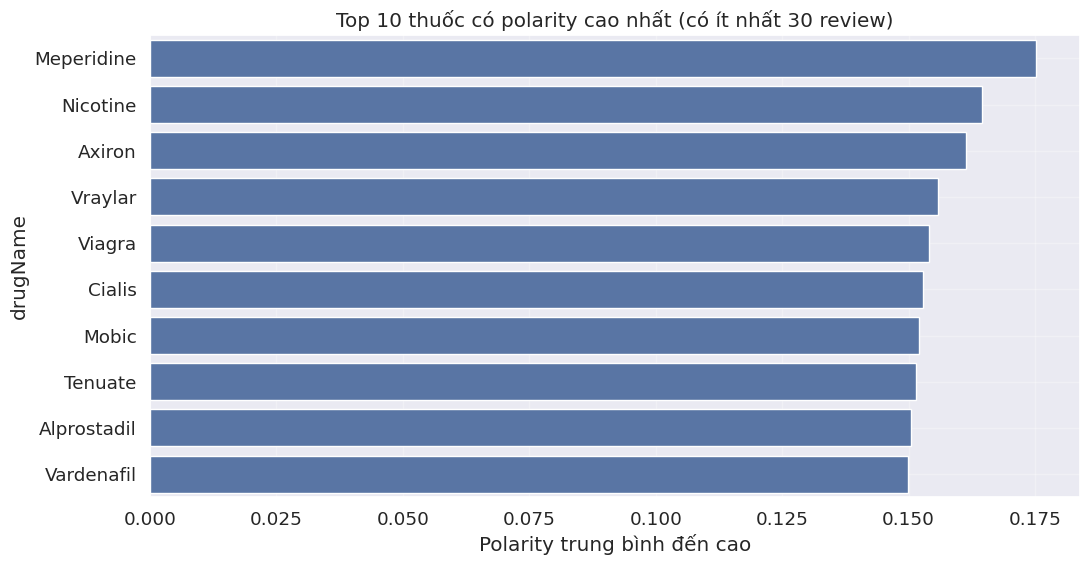

In [ ]:
# Top 10 thuốc có polarity cao nhất
top_polarity_drugs = drug_stats.sort_values('polarity_mean', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='polarity_mean', y='drugName', data=top_polarity_drugs)
plt.title(f'Top 10 thuốc có polarity cao nhất (có ít nhất {min_reviews} review)')
plt.xlabel('Polarity trung bình đến cao')
plt.grid(True, alpha=0.3)
plt.show()

Biểu đồ polarity cho thấy những thuốc này thường nhận được phản hồi mạnh mẽ từ người dùng.
Có một số nhóm thuốc nổi bật xuất hiện nhiều lần trong danh sách:

- Thuốc điều trị rối loạn cương dương (ED): Viagra, Cialis, Alprostadil, Vardenafil
- Thuốc tác động đến hệ thần kinh: Meperidine (giảm đau), Nicotine, Vraylar (điều trị tâm thần)
- Meperidine, thuốc giảm đau opioid, có mức độ polarity cao nhất, điều này có thể phản ánh ý kiến trái chiều về hiệu quả giảm đau và tác dụng phụ/nguy cơ nghiện của nó.
- Nicotine cũng có polarity cao, có thể do một số người thấy các sản phẩm nicotine rất hiệu quả trong việc cai thuốc lá, trong khi những người khác có thể gặp phải tác dụng phụ hoặc không đạt được kết quả mong muốn.
- Đáng chú ý là có 4 loại thuốc điều trị rối loạn cương dương trong danh sách, cho thấy đây là nhóm thuốc thường gây ra phản ứng mạnh mẽ và trái chiều từ người dùng.
- Tất cả các giá trị polarity đều khá gần nhau (từ 0,14 đến 0,175), cho thấy mức độ phân cực ý kiến tương đối đồng đều giữa các loại thuốc này.

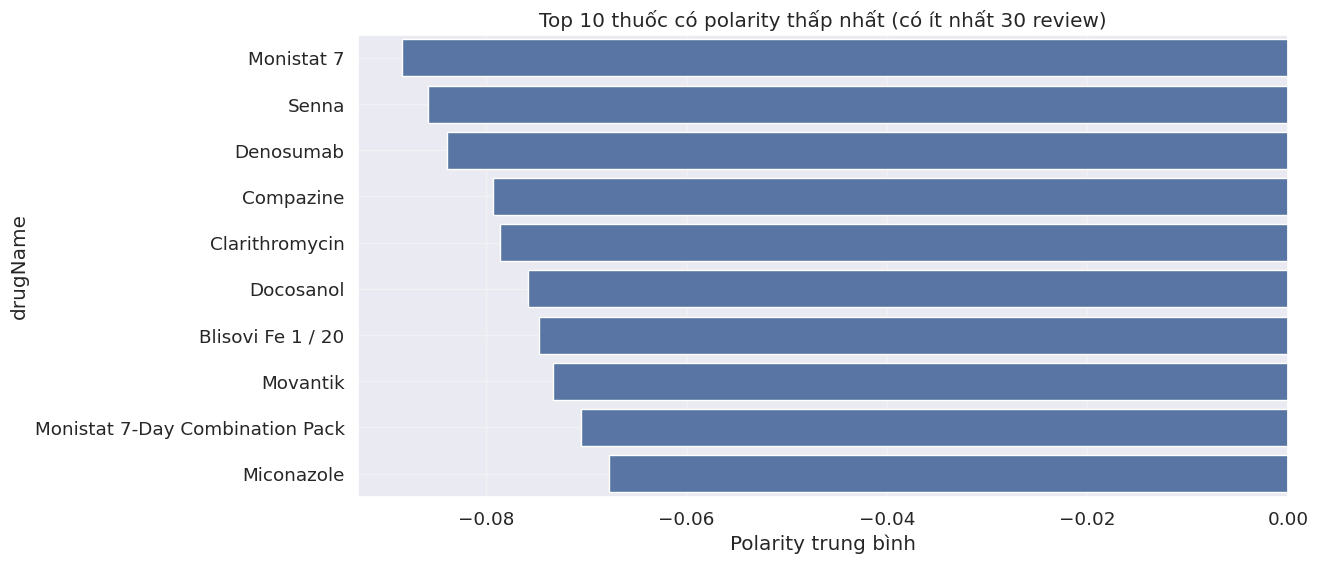

In [ ]:
# Top 10 thuốc có polarity thấp nhất
lowest_polarity_drugs = drug_stats.sort_values('polarity_mean').head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='polarity_mean', y='drugName', data=lowest_polarity_drugs)
plt.title(f'Top 10 thuốc có polarity thấp nhất (có ít nhất {min_reviews} review)')
plt.xlabel('Polarity trung bình')
plt.grid(True, alpha=0.3)
plt.show()


Nhìn chung, các giá trị polarity trong danh sách này nằm trong khoảng từ -0,09 đến -0,05, tuy nhiên polarity thấp không đồng nghĩa với đánh giá tiêu cực - nó chỉ cho thấy mức độ biến thiên trong đánh giá thấp. Có một số nhóm thuốc xuất hiện nhiều lần trong danh sách:

- Thuốc chống nấm âm đạo: Monistat 7, Monistat 7-Day Combination Pack, Miconazole
- Thuốc điều trị tiêu hóa: Senna (nhuận tràng), Movantik (trị táo bón do opioid)

Đáng chú ý là cả Monistat 7 và Monistat 7-Day Combination Pack đều xuất hiện trong danh sách, nhưng với mức polarity khác nhau (-0,09 và -0,055), cho thấy sự khác biệt về tính đồng nhất trong đánh giá của người dùng. ( khá tương đồng khi 2 loại thuốc này cũng có rating trung bình khá thấp )  
Một số thuốc trong danh sách này cũng xuất hiện trong Top 10 thuốc có rating thấp nhất (từ biểu đồ trước), như Monistat 7, Denosumab, Compazine, Blisovi Fe 1/20 và Miconazole. Điều này gợi ý rằng những thuốc này không chỉ có đánh giá thấp mà còn có tính đồng nhất cao trong đánh giá (đa số người dùng đều đánh giá tương tự nhau).  
Polarity âm thấp nhất là -0,09 (Monistat 7) cho thấy mức độ phân cực không quá cao, nghĩa là ngay cả thuốc có polarity "thấp nhất" cũng không có sự phân hóa quá mạnh trong đánh giá.

In [ ]:
# So sánh xếp hạng theo rating và polarity
top_drugs_comparison = pd.merge(
    drug_stats[['drugName', 'rating_mean']].sort_values('rating_mean', ascending=False).head(10).reset_index(drop=True),
    drug_stats[['drugName', 'polarity_mean']].sort_values('polarity_mean', ascending=False).head(10).reset_index(drop=True),
    left_index=True, right_index=True, suffixes=('_rating', '_polarity')
)
print("So sánh top 10 thuốc theo rating và polarity:")
top_drugs_comparison

So sánh top 10 thuốc theo rating và polarity:


drugName_rating  rating_mean  \
0                                Silver sulfadiazine    10.000000   
1                                           Stribild     9.543478   
2                                               Soma     9.507463   
3  Cobicistat / elvitegravir / emtricitabine / te...     9.435897   
4                                         Meperidine     9.433333   
5                                     Diethylpropion     9.382353   
6                     Chlorpheniramine / hydrocodone     9.319149   
7                                       Carisoprodol     9.308642   
8                                             Drysol     9.257143   
9                                            Campral     9.250000   

  drugName_polarity  polarity_mean  
0        Meperidine       0.175120  
1          Nicotine       0.164490  
2            Axiron       0.161420  
3           Vraylar       0.155860  
4            Viagra       0.154067  
5            Cialis       0.152776  
6             Mobic       0.151997  
7           Tenuate       0.151476  
8       Alprostadil       0.150439  
9        Vardenafil       0.149922

1. **Meperidine** là trường hợp đặc biệt khi xuất hiện trong cả hai danh sách:
   - Đứng vị trí thứ 5 trong top 10 thuốc có rating cao nhất (9.433333)
   - Đứng đầu trong top 10 thuốc có polarity cao nhất (0.175120)
   Điều này cho thấy Meperidine điển hình cho loại thuốc có hiệu quả rõ rệt nhưng cũng gây lo ngại về tác dụng phụ.
3. **Không có sự trùng lặp nhiều** giữa hai danh sách, chỉ có một thuốc (Meperidine) xuất hiện ở cả hai. Điều này cho thấy thuốc được đánh giá cao không nhất thiết là thuốc có ý kiến phân cực mạnh.
1. **Thuốc có rating cao nhất** là Silver sulfadiazine (10/10 điểm) - một loại thuốc kháng sinh dạng kem bôi ngoài da điều trị vết bỏng. Sự thống nhất trong đánh giá cao này có thể phản ánh hiệu quả nhất quán của thuốc trong mục đích sử dụng cụ thể.
2. **Thuốc có polarity cao nhất** là Meperidine (0.175120) - một thuốc giảm đau opioid. Đây là thuốc vừa được đánh giá cao (top 5 về rating) vừa gây tranh cãi (đứng đầu về polarity), phản ánh thực tế rằng các thuốc opioid thường vừa có hiệu quả giảm đau tốt vừa gây lo ngại về tác dụng phụ và khả năng gây nghiện.
3. **Sự khác biệt về loại thuốc** giữa hai danh sách khá rõ rệt:
   - Danh sách rating cao tập trung vào thuốc điều trị đa dạng các bệnh lý
   - Danh sách polarity cao tập trung vào các thuốc liên quan đến chức năng sinh lý (ED) và tác động đến tâm thần/thần kinh.  
Việc so sánh hai danh sách này cho thấy rating cao và polarity cao đo lường hai khía cạnh khác nhau của phản hồi của người dùng:
- **Rating cao** phản ánh sự hài lòng tổng thể với thuốc
- **Polarity cao** phản ánh sự phân cực trong đánh giá (có nhiều ý kiến rất tích cực và rất tiêu cực)

##  Phân tích mối quan hệ giữa thuốc, bệnh, và polarity

In [ ]:
# Tạo DataFrame cho các cặp thuốc-bệnh
drug_condition_stats = df_drug.groupby(['drugName', 'condition']).agg({
    'rating': ['mean', 'count'],
    'polarity': 'mean'
}).reset_index()

drug_condition_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in drug_condition_stats.columns.values]

# Lọc các cặp thuốc-bệnh có ít nhất 10 review
popular_pairs = drug_condition_stats[drug_condition_stats['rating_count'] >= 10]


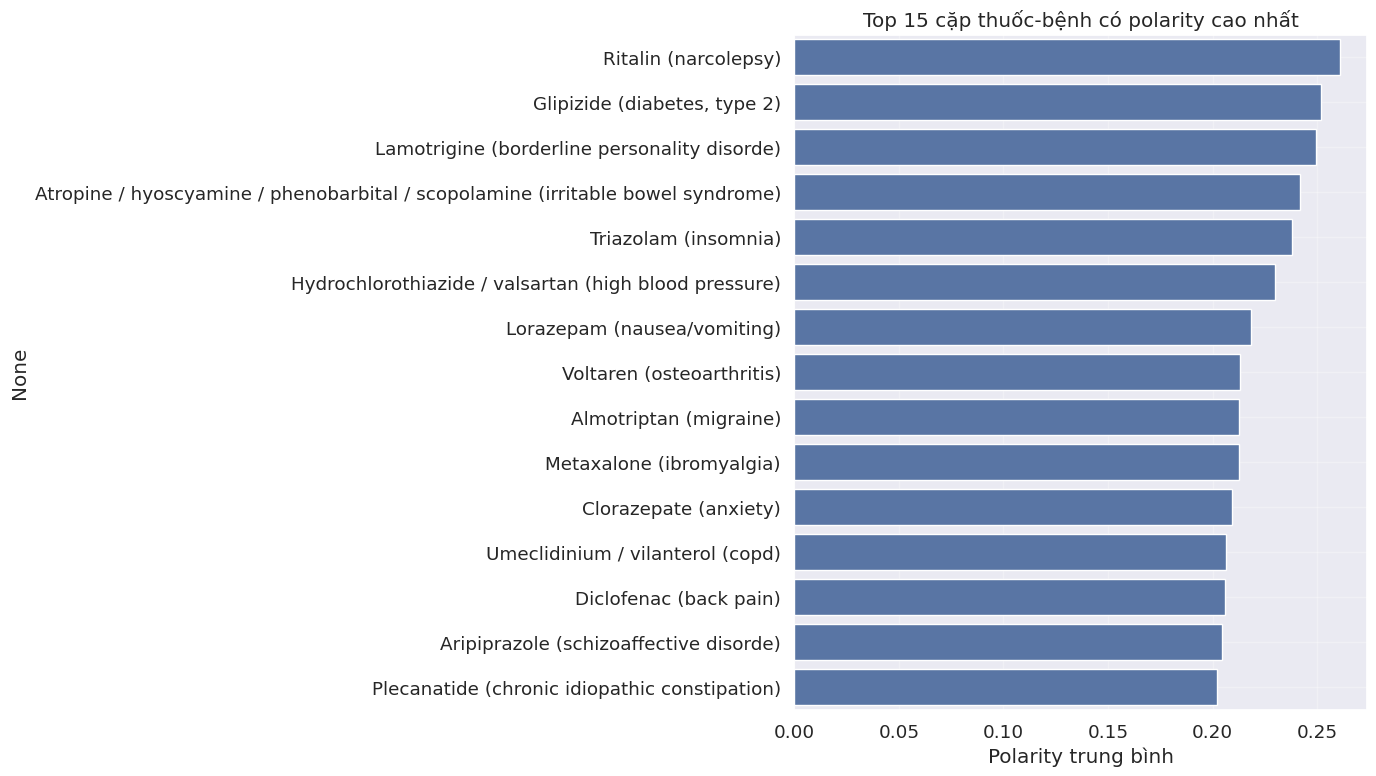

In [ ]:
# Top 15 cặp thuốc-bệnh có polarity cao nhất
top_pairs = popular_pairs.sort_values('polarity_mean', ascending=False).head(15)
plt.figure(figsize=(14, 8))
sns.barplot(x='polarity_mean', y=top_pairs['drugName'] + ' (' + top_pairs['condition'] + ')', data=top_pairs)
plt.title('Top 15 cặp thuốc-bệnh có polarity cao nhất')
plt.xlabel('Polarity trung bình')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Những cặp thuốc-bệnh có polarity cao nhất:

1. **Ritalin (narcolepsy)** - polarity khoảng 0,25: Thuốc kích thích hệ thần kinh trung ương được sử dụng điều trị chứng ngủ rũ.

2. **Glipizide (diabetes, type 2)** - polarity khoảng 0,24: Thuốc uống làm giảm đường huyết trong điều trị đái tháo đường type 2.

3. **Lamotrigine (borderline personality disorder)** - polarity khoảng 0,23: Thuốc chống động kinh được sử dụng ngoài chỉ định cho rối loạn nhân cách biên.

4. **Atropine/hyoscyamine/phenobarbital/scopolamine (irritable bowel syndrome)** - polarity khoảng 0,23: Kết hợp thuốc điều trị hội chứng ruột kích thích.

5. **Triazolam (insomnia)** - polarity khoảng 0,22: Thuốc ngủ benzodiazepine điều trị mất ngủ.

### Phân tích theo nhóm bệnh lý:

1. **Rối loạn tâm thần và thần kinh**:
   - Ritalin (narcolepsy) - polarity cao nhất
   - Lamotrigine (borderline personality disorder)
   - Triazolam (insomnia)
   - Clorazepate (anxiety)
   - Aripiprazole (schizoaffective disorder)

2. **Đau và viêm**:
   - Voltaren (osteoarthritis)
   - Metaxalone (fibromyalgia)
   - Diclofenac (back pain)

3. **Rối loạn tiêu hóa**:
   - Atropine/hyoscyamine/phenobarbital/scopolamine (irritable bowel syndrome)
   - Lorazepam (nausea/vomiting)
   - Plecanatide (chronic idiopathic constipation)

4. **Bệnh mạn tính khác**:
   - Glipizide (diabetes, type 2)
   - Hydrochlorothiazide/valsartan (high blood pressure)
   - Umeclidinium/vilanterol (copd)

### Nhận xét chung:

1. **Thuốc tác động đến thần kinh chiếm ưu thế**: Trong top 15, có nhiều thuốc tác động đến hệ thần kinh trung ương như Ritalin, Lamotrigine, Triazolam, Lorazepam, Clorazepate và Aripiprazole. Điều này cho thấy thuốc tác động đến thần kinh thường gây ra phản ứng mạnh mẽ và trái chiều từ người dùng.

2. **Bệnh mạn tính và khó điều trị**: Nhiều cặp thuốc-bệnh trong danh sách liên quan đến các bệnh mạn tính khó điều trị như đái tháo đường type 2, rối loạn nhân cách biên, hội chứng ruột kích thích, đau mạn tính và bệnh phổi tắc nghẽn mạn tính (COPD).

3. **Polarity cao phản ánh tính phức tạp trong điều trị**: Chỉ số polarity cao cho thấy những thuốc này gây ra phản ứng khác nhau đáng kể giữa các bệnh nhân - một số thấy hiệu quả rõ rệt, trong khi những người khác có thể gặp phải tác dụng phụ nghiêm trọng hoặc không đạt được kết quả mong muốn.

4. **Sự xuất hiện của thuốc gây nghiện**: Một số thuốc có tiềm năng gây nghiện như Triazolam, Lorazepam và Clorazepate (thuộc nhóm benzodiazepine) có mặt trong danh sách, cho thấy những thuốc này thường gây ra phản ứng trái ngược giữa lợi ích trị liệu và lo ngại về tác dụng phụ/nghiện.

5. **Thuốc cho các bệnh rối loạn tâm thần**: Thuốc điều trị các rối loạn như nhân cách biên (Lamotrigine), rối loạn cảm xúc phân liệt (Aripiprazole) và lo âu (Clorazepate) xuất hiện nhiều trong danh sách, phản ánh tính phức tạp của việc điều trị các rối loạn tâm thần.

### Kết luận:

Polarity cao trong các cặp thuốc-bệnh này cho thấy có sự phân cực trong đánh giá của bệnh nhân, phản ánh thực tế rằng hiệu quả của thuốc có thể khác nhau đáng kể giữa các cá nhân. Đặc biệt là với các thuốc tác động đến hệ thần kinh và các bệnh mạn tính phức tạp, sự phản hồi có thể rất trái ngược nhau. Điều này nhấn mạnh tầm quan trọng của việc điều trị cá nhân hóa và theo dõi cẩn thận phản ứng của bệnh nhân với thuốc điều trị.

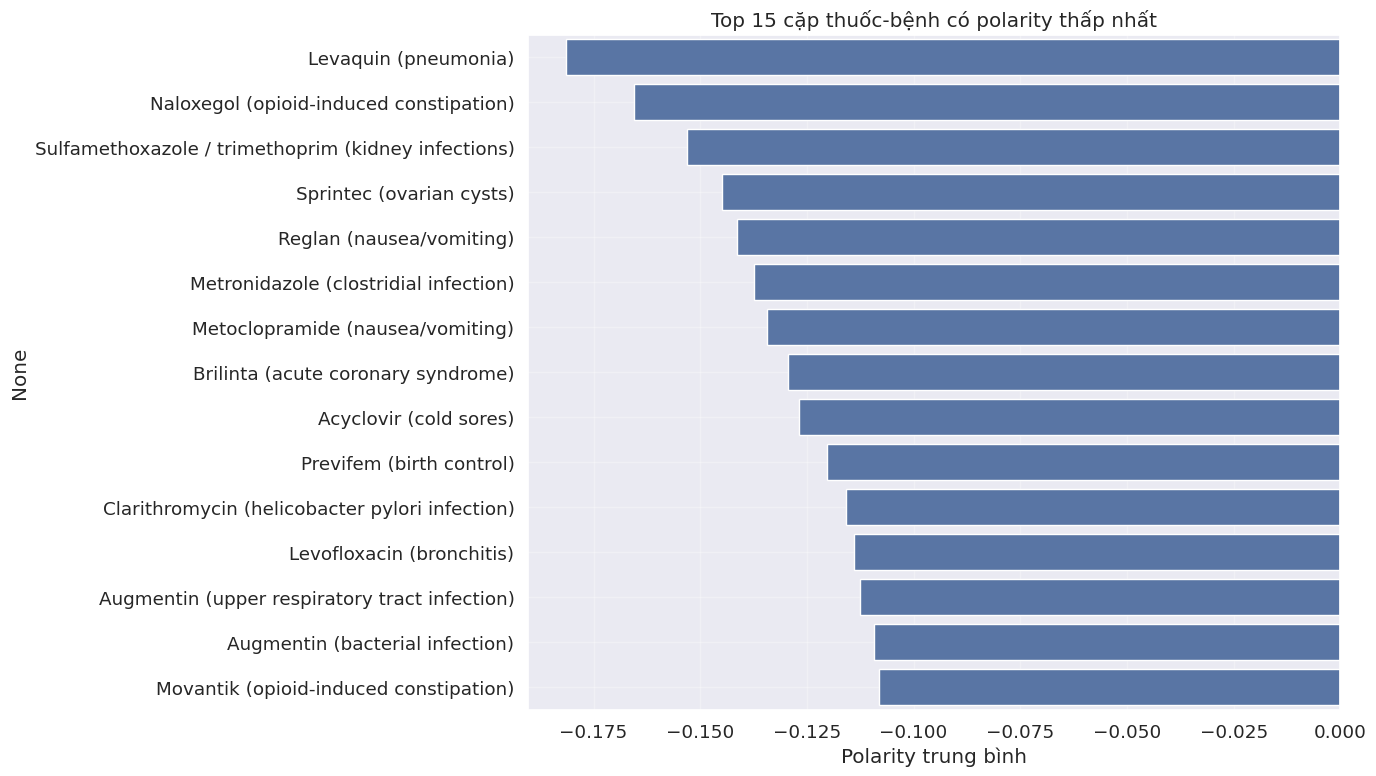

In [ ]:
# Top 15 cặp thuốc-bệnh có polarity thấp nhất
bottom_pairs = popular_pairs.sort_values('polarity_mean').head(15)
plt.figure(figsize=(14, 8))
sns.barplot(x='polarity_mean', y=bottom_pairs['drugName'] + ' (' + bottom_pairs['condition'] + ')', data=bottom_pairs)
plt.title('Top 15 cặp thuốc-bệnh có polarity thấp nhất')
plt.xlabel('Polarity trung bình')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Phân tích theo nhóm bệnh lý
1. **Nhiễm trùng/nhiễm khuẩn**: Chiếm phần lớn danh sách (8/15 cặp), bao gồm:
   - Levaquin (viêm phổi)
   - Sulfamethoxazole/trimethoprim (nhiễm trùng thận)
   - Metronidazole (nhiễm trùng clostridial)
   - Acyclovir (mụn rộp)
   - Clarithromycin (nhiễm H. pylori)
   - Levofloxacin (viêm phế quản)
   - Augmentin (nhiễm trùng đường hô hấp trên)
   - Augmentin (nhiễm khuẩn nói chung)

2. **Rối loạn tiêu hóa**: 4 cặp thuốc-bệnh:
   - Naloxegol (táo bón do opioid)
   - Reglan (buồn nôn/nôn)
   - Metoclopramide (buồn nôn/nôn)
   - Movantik (táo bón do opioid)

3. **Các bệnh khác**:
   - Sprintec (u nang buồng trứng)
   - Brilinta (hội chứng mạch vành cấp)
   - Previfem (kiểm soát sinh đẻ)

1. **Thuốc trùng lặp**:
   - Augmentin xuất hiện hai lần với polarity khác nhau cho hai chỉ định khác nhau (-0.075 cho nhiễm trùng đường hô hấp trên và -0.05 cho nhiễm khuẩn nói chung)
   - Metoclopramide và Reglan về cơ bản là cùng một thuốc (metoclopramide) với tên thương mại khác nhau, cả hai đều điều trị buồn nôn/nôn.
3. **Kháng sinh chiếm phần lớn**: 7/15 cặp thuốc là kháng sinh với polarity thấp cho thấy có thể có vấn đề về hiệu quả hoặc tác dụng phụ.

1. **Polarity thấp có thể phản ánh**:
   - Tác dụng phụ nghiêm trọng
   - Hiệu quả điều trị hạn chế
   - Tương tác thuốc bất lợi
   - Đánh giá tiêu cực từ bệnh nhân  
Trong đó:  
2. Levaquin (viêm phổi) có polarity âm nhất, đáng chú ý vì đây là kháng sinh fluoroquinolone đã được FDA cảnh báo về tác dụng phụ nghiêm trọng.

3. Các thuốc chống nôn và điều trị táo bón do opioid có polarity thấp có thể phản ánh hiệu quả không như mong đợi hoặc tác dụng không mong muốn trong việc quản lý triệu chứng.


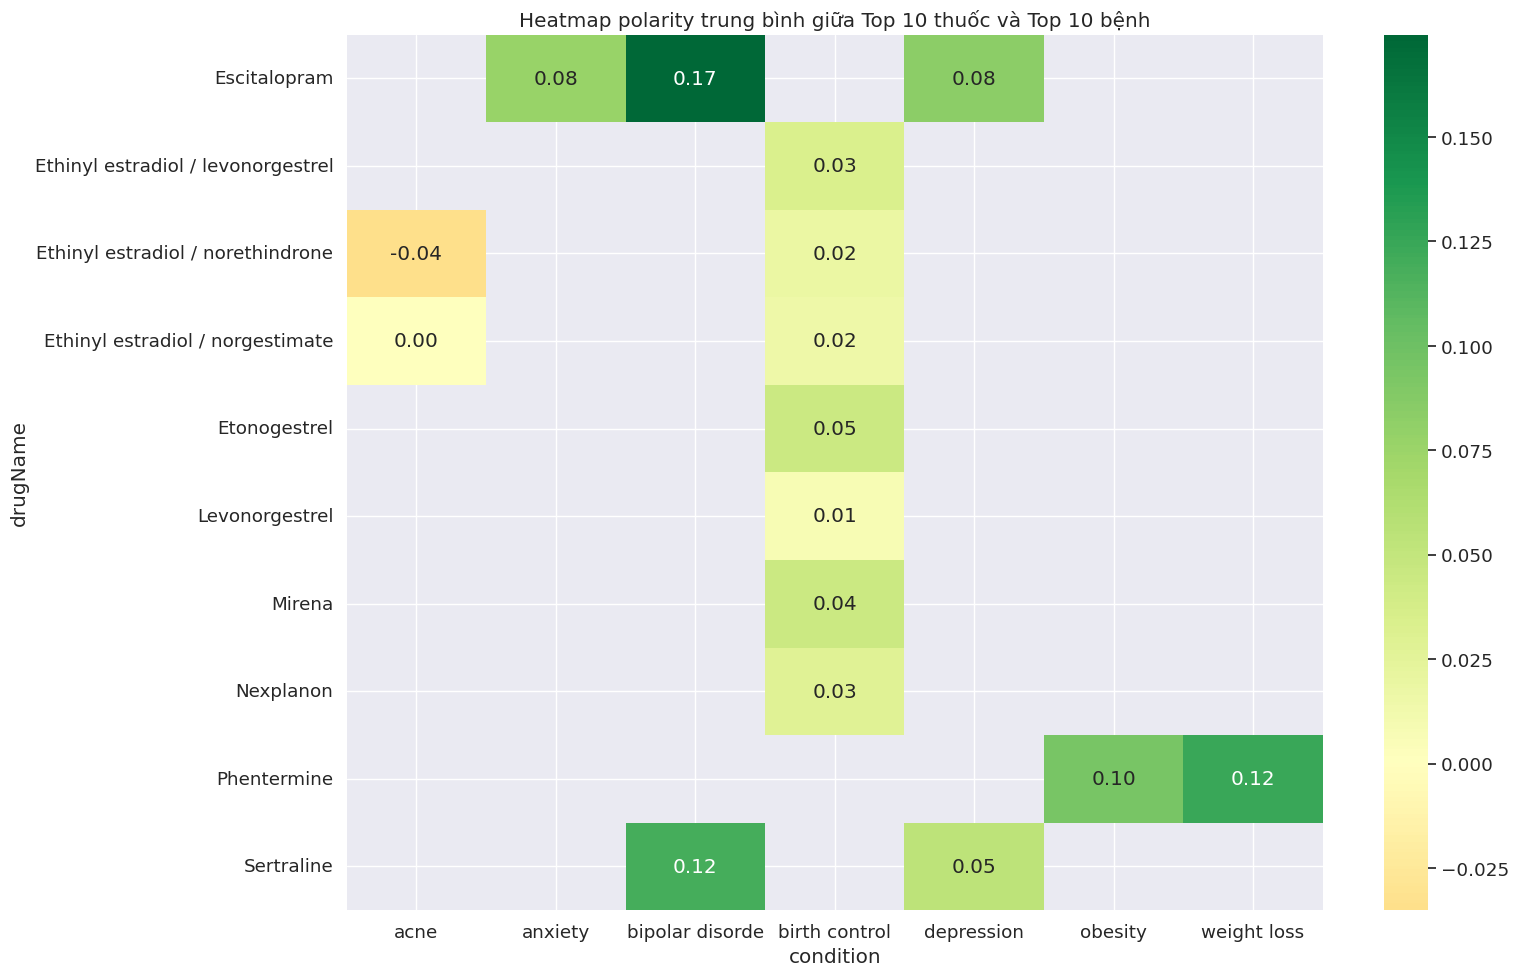

In [ ]:
# Tạo heatmap cho thuốc-bệnh-polarity cho top thuốc và top bệnh
top_drugs = df_drug['drugName'].value_counts().nlargest(10).index
top_conditions = df_drug['condition'].value_counts().nlargest(10).index

top_drug_condition_df = df_drug[(df_drug['drugName'].isin(top_drugs)) & (df_drug['condition'].isin(top_conditions))]
pivot_table = pd.pivot_table(
    top_drug_condition_df,
    values='polarity',
    index='drugName',
    columns='condition',
    aggfunc='mean'
)

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title('Heatmap polarity trung bình giữa Top 10 thuốc và Top 10 bệnh')
plt.tight_layout()
plt.show()

### Tổng quan
- Biểu đồ hiển thị mối quan hệ polarity giữa 10 loại thuốc và 7 tình trạng sức khỏe.
- Giá trị polarity dao động từ -0.04 (âm nhất) đến 0.17 (dương nhất).  

### Phân tích theo nhóm thuốc
1. **Thuốc điều trị rối loạn tâm thần**
   - Escitalopram có polarity cao nhất khi điều trị rối loạn lưỡng cực (0.17) và có hiệu quả tích cực với lo âu và trầm cảm (0.08)
   - Sertraline cũng có polarity cao với rối loạn lưỡng cực (0.12) và trầm cảm (0.05)

2. **Thuốc kiểm soát cân nặng**
   - Phentermine có polarity tích cực với cả béo phì (0.10) và giảm cân (0.12)

3. **Thuốc tránh thai/nội tiết**
   - Nhóm ethinyl estradiol với các progestin khác nhau có polarity dao động từ âm (-0.04 với mụn trứng cá) đến dương nhẹ (0.03 cho kiểm soát sinh đẻ)
   - Etonogestrel, Levonorgestrel, Mirena và Nexplanon đều được sử dụng chủ yếu cho kiểm soát sinh đẻ với polarity dương nhẹ (từ 0.01 đến 0.05)

### Phân tích theo bệnh lý
1. **Rối loạn lưỡng cực**: Có polarity cao nhất trong biểu đồ với Escitalopram (0.17) và Sertraline (0.12)
2. **Giảm cân & béo phì**: Phentermine cho kết quả tích cực (0.10-0.12)
3. **Trầm cảm**: Được điều trị hiệu quả bởi Escitalopram (0.08) và Sertraline (0.05)
4. **Kiểm soát sinh đẻ**: Đa số thuốc tránh thai có polarity dương nhẹ (0.01-0.05)
5. **Lo âu**: Escitalopram cho polarity dương (0.08)
6. **Mụn trứng cá**: Chỉ có 3 thuốc liên quan, với ethinyl estradiol/norethindrone cho polarity âm (-0.04)  

### Điểm nổi bật
1. **Cặp thuốc-bệnh tốt nhất**: Escitalopram cho rối loạn lưỡng cực (0.17)
2. **Cặp thuốc-bệnh kém nhất**: Ethinyl estradiol/norethindrone cho mụn trứng cá (-0.04)
3. **Polarity cao nhất theo nhóm bệnh**:
   - Rối loạn lưỡng cực: Escitalopram (0.17)
   - Giảm cân: Phentermine (0.12)
   - Lo âu: Escitalopram (0.08)
   - Trầm cảm: Escitalopram (0.08)
   - Béo phì: Phentermine (0.10)
   - Kiểm soát sinh đẻ: Etonogestrel (0.05)

### Nhận xét chung:
1. Các thuốc tác động đến hệ thần kinh trung ương (Escitalopram, Sertraline, Phentermine) có xu hướng nhận được polarity cao hơn các thuốc tránh thai
2. Đa số các cặp thuốc-bệnh trong biểu đồ có polarity dương, cho thấy đánh giá tích cực nhiều hơn tiêu cực
3. Rối loạn lưỡng cực là bệnh lý có polarity cao nhất khi điều trị với các thuốc phù hợp
4. Các thuốc tránh thai dù đa dạng về thành phần nhưng có polarity khá đồng đều và tương đối thấp (dưới 0.05)

## Phân tích độ chênh lệch giữa rating và polarity theo thuốc

In [ ]:
# Tạo biến thể hiện sự chênh lệch giữa rating và polarity
# Chuẩn hóa rating về thang [-1, 1] để so sánh với polarity
df_drug['normalized_rating'] = (df_drug['rating'] - 5) / 5  # Chuyển [0-10] -> [-1, 1]
df_drug['rating_polarity_diff'] = df_drug['normalized_rating'] - df_drug['polarity']


In [ ]:
# Top 10 thuốc có độ chênh lệch lớn nhất (người dùng đánh giá cao nhưng sentiment thấp)
drug_diff_stats = df_drug.groupby('drugName').agg({
    'rating_polarity_diff': ['mean', 'std', 'count'],
    'rating': 'mean',
    'polarity': 'mean'
}).reset_index()

drug_diff_stats.columns = ['_'.join(col).strip() if col[1] else col[0] for col in drug_diff_stats.columns.values]
# Lọc thuốc có ít nhất 20 review
drug_diff_stats = drug_diff_stats[drug_diff_stats['rating_polarity_diff_count'] >= 20]


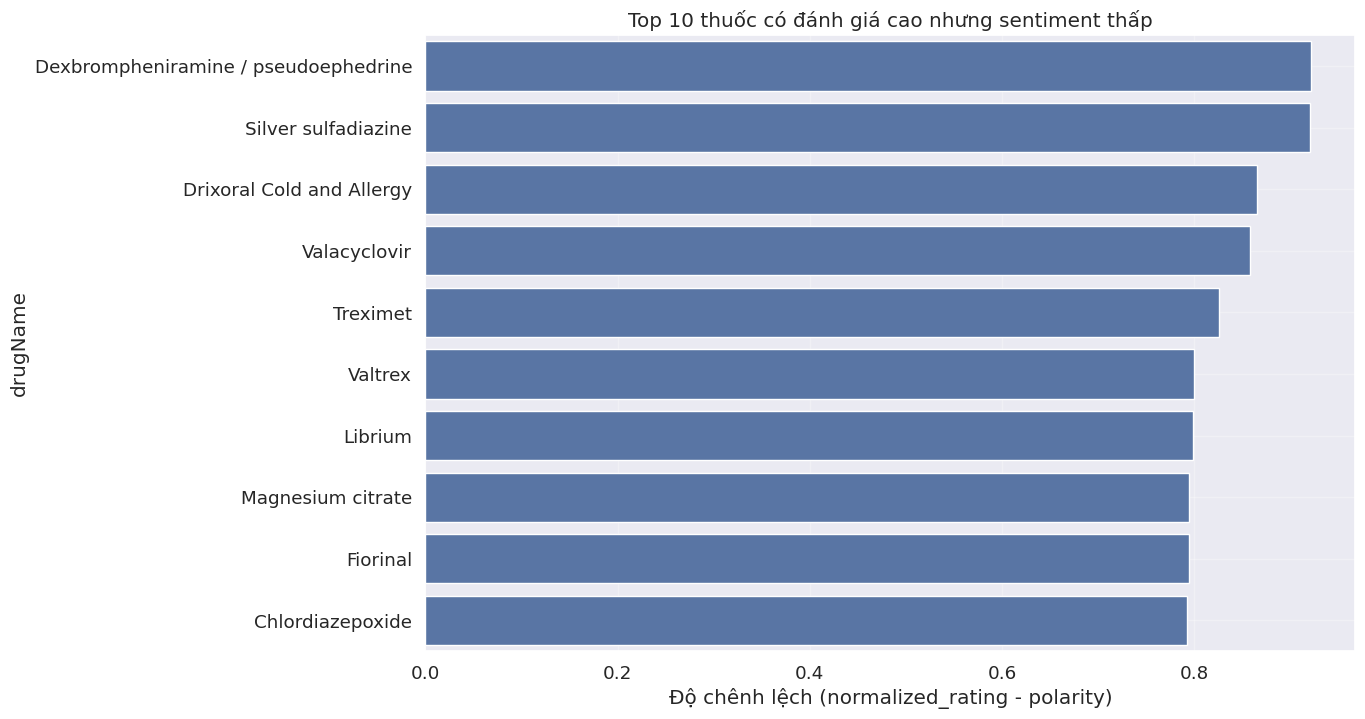

In [ ]:
# Thuốc có rating cao nhưng polarity thấp (chênh lệch dương lớn)
positive_diff_drugs = drug_diff_stats.sort_values('rating_polarity_diff_mean', ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='rating_polarity_diff_mean', y='drugName', data=positive_diff_drugs)
plt.title('Top 10 thuốc có đánh giá cao nhưng sentiment thấp')
plt.xlabel('Độ chênh lệch (normalized_rating - polarity)')
plt.grid(True, alpha=0.3)
plt.show()

1. **Thuốc kháng virus**: Valacyclovir, Valtrex (là tên thương mại của valacyclovir)
2. **Thuốc kháng histamine/cảm lạnh**: Dexbrompheniramine/pseudoephedrine, Drixoral Cold and Allergy
3. **Thuốc tác động thần kinh**: Librium, Chlordiazepoxide (là thành phần hoạt chất của Librium), Fiorinal
4. **Thuốc giảm đau đầu/đau nửa đầu**: Treximet
5. **Các loại khác**: Silver sulfadiazine (thuốc kháng khuẩn dùng ngoài da), Magnesium citrate (nhuận tràng)

### Phân tích tổng quan
- Biểu đồ cho thấy 10 loại thuốc có sự khác biệt lớn nhất giữa điểm đánh giá và phân tích cảm xúc từ nhận xét
- Mọi giá trị đều dương và cao (từ khoảng 0.7 đến 0.9), cho thấy sự không nhất quán đáng kể
- Khoảng chênh lệch này có nghĩa là người dùng đã cho điểm đánh giá cao nhưng lại viết nhận xét với tone tiêu cực

### Phân tích chi tiết theo thuốc
1. **Dexbrompheniramine/pseudoephedrine** và **Silver sulfadiazine**: Có độ chênh lệch cao nhất (khoảng 0.9), cho thấy sự mâu thuẫn rõ rệt nhất giữa đánh giá số và nội dung nhận xét

2. **Drixoral Cold and Allergy** và **Valacyclovir**: Xếp hạng tiếp theo với độ chênh lệch khoảng 0.85

3. **Các thuốc còn lại** (Treximet, Valtrex, Librium, Magnesium citrate, Fiorinal, Chlordiazepoxide): Có độ chênh lệch từ khoảng 0.75 đến 0.8

### Các lý do có thể giải thích cho sự chênh lệch
1. **Hiệu quả trên triệu chứng vs tác dụng phụ**: Thuốc có thể hiệu quả trong điều trị (dẫn đến đánh giá cao) nhưng gây tác dụng phụ khó chịu (dẫn đến nhận xét tiêu cực)

2. **Tâm lý đánh giá**: Người dùng có thể muốn "giúp đỡ" thuốc bằng cách cho điểm cao nhưng vẫn trung thực về trải nghiệm thực tế trong nhận xét

3. **Thuốc kê đơn**: Nhiều thuốc trong danh sách là thuốc kê đơn có hiệu quả được công nhận (dẫn đến đánh giá cao) nhưng có thể không thoải mái khi sử dụng (dẫn đến nhận xét tiêu cực)

4. **Kỳ vọng vs thực tế**: Người dùng có thể có kỳ vọng cao dựa trên chỉ định và danh tiếng của thuốc (cho điểm cao) nhưng thất vọng với kết quả thực tế (nhận xét tiêu cực)

5. **Tính phức tạp của bệnh**: Một số thuốc này điều trị các bệnh phức tạp (như đau nửa đầu, rối loạn lo âu) mà kết quả có thể khác nhau giữa các cá nhân

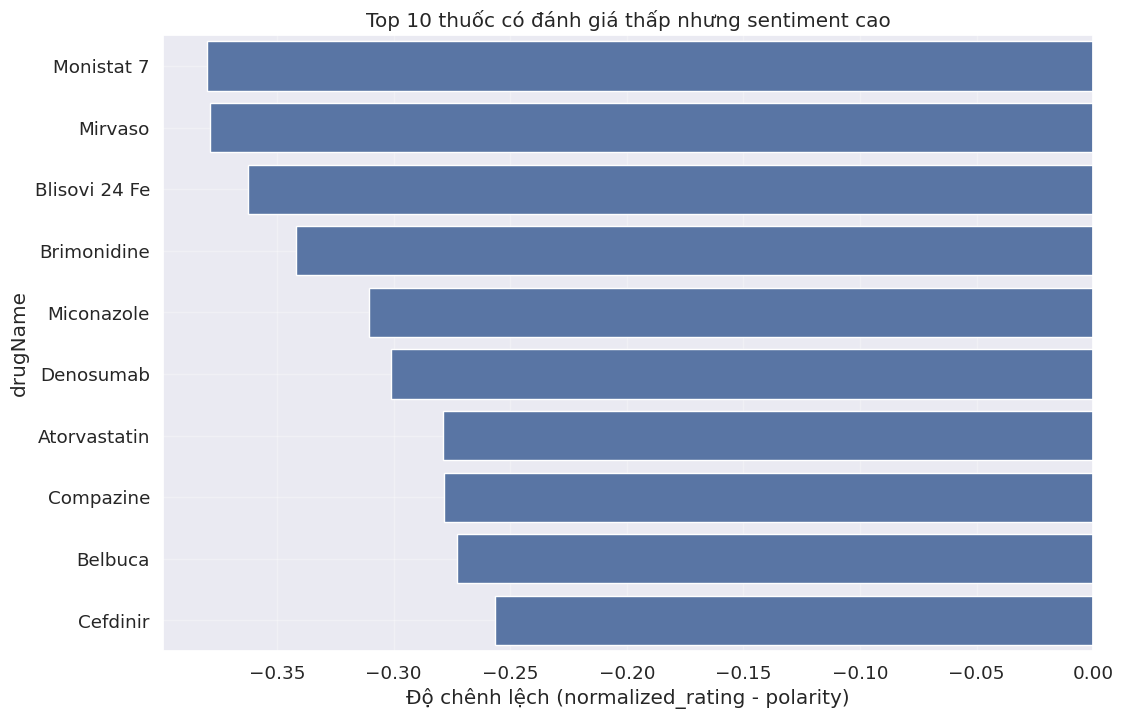

In [ ]:
# Thuốc có rating thấp nhưng polarity cao (chênh lệch âm lớn)
negative_diff_drugs = drug_diff_stats.sort_values('rating_polarity_diff_mean').head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x='rating_polarity_diff_mean', y='drugName', data=negative_diff_drugs)
plt.title('Top 10 thuốc có đánh giá thấp nhưng sentiment cao')
plt.xlabel('Độ chênh lệch (normalized_rating - polarity)')
plt.grid(True, alpha=0.3)
plt.show()

### Phân nhóm theo công dụng
1. **Thuốc chống nấm**: Monistat 7 (miconazole), Miconazole
2. **Thuốc nội tiết/tránh thai**: Blisovi 24 Fe
3. **Thuốc tim mạch/huyết áp**: Mirvaso (brimonidine topical), Brimonidine (nhỏ mắt), Atorvastatin
4. **Thuốc điều trị loãng xương**: Denosumab
5. **Thuốc chống nôn**: Compazine (prochlorperazine)
6. **Thuốc giảm đau**: Belbuca (buprenorphine)
7. **Kháng sinh**: Cefdinir

### Phân tích tổng quan
- Giá trị âm này cho thấy polarity (từ phân tích nhận xét) cao hơn đáng kể so với điểm đánh giá chuẩn hóa
- Thuốc ở đầu danh sách có sự chênh lệch lớn nhất, nghĩa là có sự mâu thuẫn rõ rệt nhất giữa đánh giá thấp và nhận xét tích cực

### Phân tích theo thuốc (từ chênh lệch lớn nhất đến nhỏ nhất)
1. **Monistat 7 và Mirvaso**: Có chênh lệch âm lớn nhất (khoảng -0.37), cho thấy mức độ không đồng nhất cao nhất

2. **Blisovi 24 Fe**: Chênh lệch khoảng -0.35

3. **Brimonidine**: Chênh lệch khoảng -0.32

4. **Miconazole và Denosumab**: Chênh lệch khoảng -0.30 và -0.28

5. **Atorvastatin và Compazine**: Chênh lệch khoảng -0.25

6. **Belbuca và Cefdinir**: Chênh lệch khoảng -0.23 và -0.20

### Nguyên nhân có thể giải thích hiện tượng này
1. **Kỳ vọng không thực tế**: Người dùng có thể có kỳ vọng quá cao nên cho điểm thấp, nhưng vẫn ghi nhận các lợi ích trong phần nhận xét

2. **Chi phí và khả năng tiếp cận**: Một số thuốc (như Denosumab, Belbuca) có giá cao, có thể khiến người dùng cho điểm thấp mặc dù công nhận hiệu quả tốt

3. **Thời gian có hiệu quả**: Một số thuốc cần thời gian dài để phát huy tác dụng (như Atorvastatin), khiến người dùng đánh giá thấp về hiệu quả ngắn hạn nhưng vẫn tích cực về tác dụng lâu dài

4. **Tác dụng phụ nhưng hiệu quả**: Thuốc có thể gây tác dụng phụ khó chịu (dẫn đến đánh giá thấp) nhưng rất hiệu quả (dẫn đến nhận xét tích cực)

5. **Mong đợi tác dụng nhanh**: Với thuốc như Blisovi 24 Fe (thuốc tránh thai) hoặc Monistat 7 (thuốc chống nấm), người dùng có thể thiếu kiên nhẫn chờ đợi kết quả

### Đặc điểm đáng chú ý
1. **Hai thuốc chống nấm** (Monistat 7 và Miconazole) có chênh lệch lớn nhất, cho thấy vấn đề đặc biệt trong cách người dùng đánh giá loại thuốc này

2. **Thuốc tim mạch** (Mirvaso, Brimonidine, Atorvastatin) chiếm một phần lớn danh sách, có thể phản ánh việc điều trị dài hạn với kết quả tốt nhưng không đáp ứng kỳ vọng ngắn hạn

3. **Thuốc kê đơn cao cấp** (Denosumab, Belbuca) xuất hiện trong danh sách, có thể liên quan đến vấn đề chi phí/tiếp cận.

##  Word Clouds và phân tích từ ngữ theo thuốc

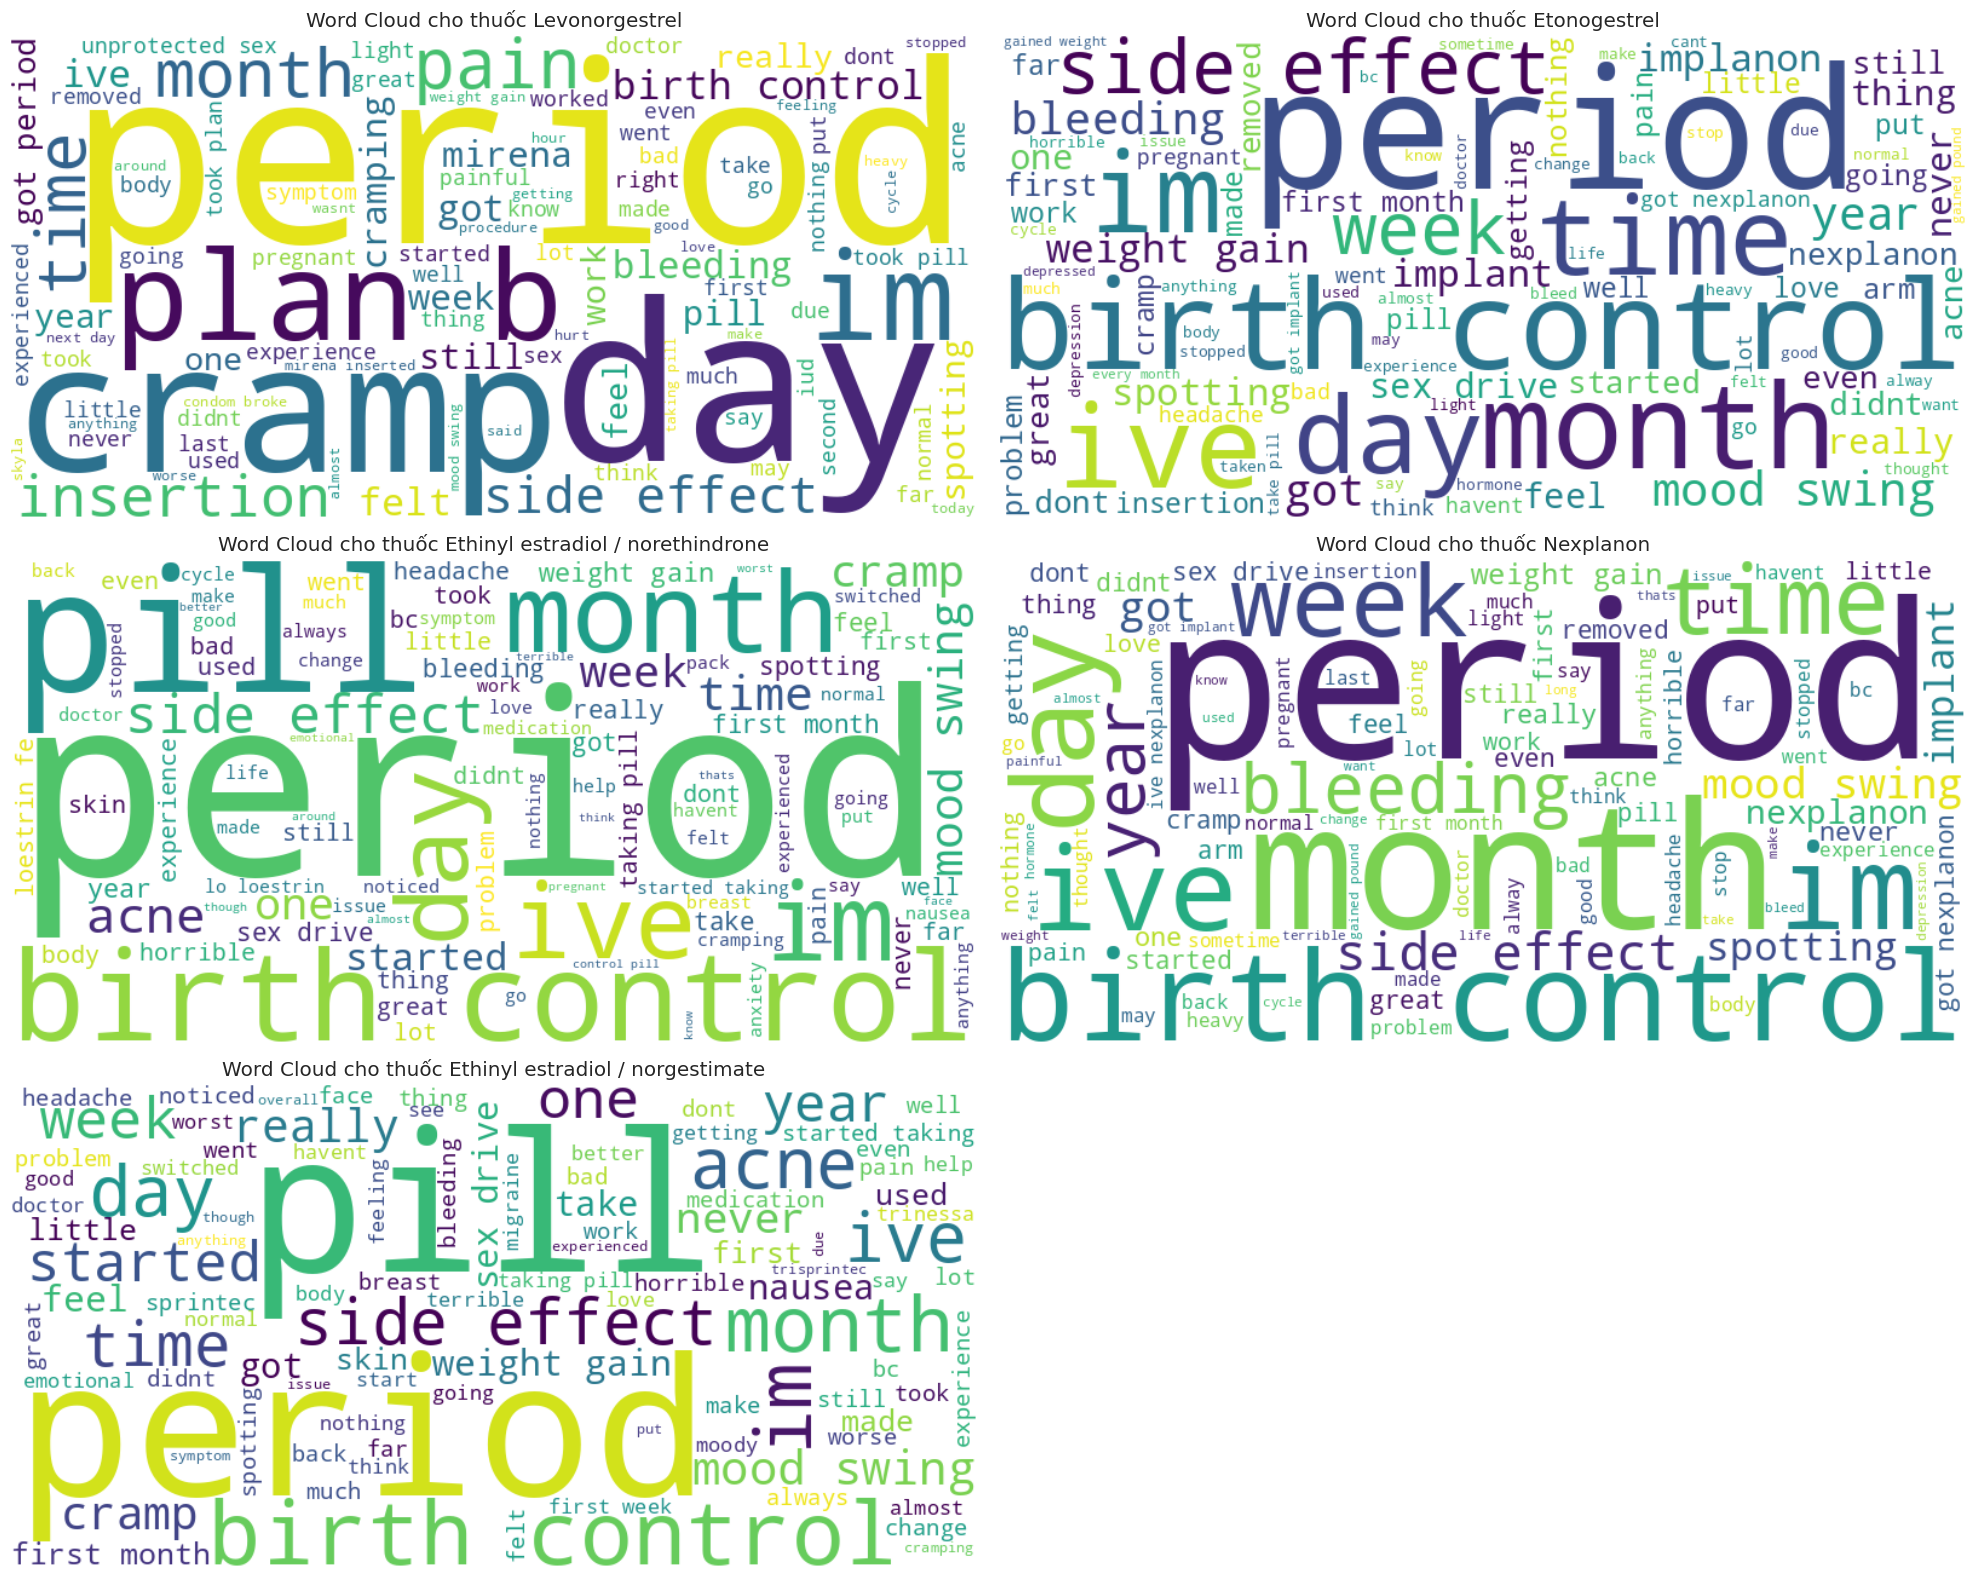

In [ ]:
from wordcloud import WordCloud

# Tạo word cloud cho top 5 thuốc phổ biến nhất
top5_drugs = df_drug['drugName'].value_counts().nlargest(5).index

plt.figure(figsize=(20, 16))
for i, drug in enumerate(top5_drugs, 1):
    drug_reviews = ' '.join(df_drug[df_drug['drugName'] == drug]['processed_review'])

    # Word cloud
    plt.subplot(3, 2, i)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, contour_width=3).generate(drug_reviews)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud cho thuốc {drug}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Nhận xét chung:
Có thể thấy thuốc được nhiều người nhắc đến nhất chính là các thuốc liên quan đến **birth control** ( thuốc tránh thai ).

#### 1. Levonorgestrel
- **Từ nổi bật nhất**: "period", "day", "bleeding"
- **Chủ đề chính**: Tập trung vào thời gian ("day", "month", "week"), kinh nguyệt ("period", "bleeding", "spotting") và cảm giác đau ("pain")
- **Từ về tác dụng phụ**: "pain", "side effect", "cramping"
- **Từ đặc biệt**: "mirena" (một thương hiệu IUD chứa levonorgestrel), "insertion" (đề cập đến quá trình đặt IUD ~ vòng tránh thai)

#### 2. Etonogestrel
- **Từ nổi bật nhất**: "period", "month", "day"
- **Chủ đề chính**: Thời gian, tác động đến chu kỳ kinh nguyệt, và kiểm soát sinh đẻ
- **Từ về tác dụng phụ**: "mood swing", "bleeding", "weight gain"
- **Từ đặc biệt**: "implant", "nexplanon" (thương hiệu que cấy tránh thai chứa etonogestrel), "insertion", "arm"

#### 3. Ethinyl estradiol/norethindrone
- **Từ nổi bật nhất**: "birth control", "pill", "period"
- **Chủ đề chính**: Tác dụng kiểm soát sinh đẻ, chu kỳ kinh nguyệt, và thời gian
- **Từ về tác dụng phụ**: "mood swing", "weight gain", "headache", "cramp"
- **Từ liên quan đến hiệu quả**: "birth control" đặc biệt nổi bật, cho thấy tính chất của thuốc

#### 4. Nexplanon
- **Từ nổi bật nhất**: "month", "period", "day"
- **Chủ đề chính**: Thời gian sử dụng, chu kỳ kinh nguyệt, và tác động
- **Từ về tác dụng phụ**: "bleeding", "mood swing", "weight gain"
- **Từ đặc biệt**: "implant", "arm", "nexplanon" - đề cập rõ đến phương pháp que cấy tránh thai

#### 5. Ethinyl estradiol/norgestimate
- **Từ nổi bật nhất**: "birth control", "period", "acne", "pill"
- **Chủ đề chính**: Kiểm soát sinh đẻ, chu kỳ kinh nguyệt, và đặc biệt là tác động đến mụn trứng cá
- **Từ về tác dụng phụ**: "acne" (đáng chú ý vì đây là thuốc đồng thời trị mụn), "mood swing", "nausea"
- **Từ đặc biệt**: Đề cập nhiều đến "acne" - khác biệt với các thuốc khác, cho thấy đây là thuốc có tác dụng kép

### Phân tích so sánh
1. **Phương pháp sử dụng phản ánh trong từ ngữ**:
   - Levonorgestrel: Từ "insertion" và "mirena" cho thấy phương pháp IUD
   - Etonogestrel và Nexplanon: Từ "arm", "implant" cho thấy phương pháp que cấy
   - Ethinyl estradiol/norethindrone và Ethinyl estradiol/norgestimate: Từ "pill" đề cập đến viên uống

2. **Tác dụng phụ đặc trưng**:
   - Mụn trứng cá ("acne") nổi bật đặc biệt trong Ethinyl estradiol/norgestimate
   - "Mood swing" xuất hiện ở hầu hết các thuốc, đặc biệt là thuốc tổng hợp
   - "Weight gain" là mối quan tâm chung với nhiều thuốc
   - "Pain" rõ nét ở Levonorgestrel, có thể liên quan đến quá trình đặt IUD

3. **Thời gian & chu kỳ**:
   - Tất cả thuốc đều chú trọng đến "month", "day", "week", "time", "period"
   - "Bleeding" và "spotting" xuất hiện ở hầu hết các thuốc, cho thấy tác động phổ biến đến chu kỳ kinh nguyệt

4. **Hiệu quả tránh thai**:
   - "Birth control" nổi bật nhất ở hai loại viên uống, đặc biệt là Ethinyl estradiol/norgestimate
   - "Pregnant" xuất hiện nhưng không quá nổi bật, có thể phản ánh hiệu quả tốt của các phương pháp này

In [ ]:
# Phân tích từ đặc trưng cho mỗi loại thuốc (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_tfidf_words(drug_name, n=10):
    drug_reviews = df_drug[df_drug['drugName'] == drug_name]['processed_review']
    other_reviews = df_drug[df_drug['drugName'] != drug_name]['processed_review']

    # Tạo corpus
    corpus = list(drug_reviews) + list(other_reviews)

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # Tính điểm TF-IDF trung bình cho mỗi từ
    feature_names = vectorizer.get_feature_names_out()
    drug_tfidf_mean = tfidf_matrix[:len(drug_reviews)].mean(axis=0).A1
    other_tfidf_mean = tfidf_matrix[len(drug_reviews):].mean(axis=0).A1

    # Tính điểm chênh lệch
    diff_scores = drug_tfidf_mean - other_tfidf_mean
    top_indices = diff_scores.argsort()[-n:][::-1]

    return [(feature_names[i], diff_scores[i]) for i in top_indices]

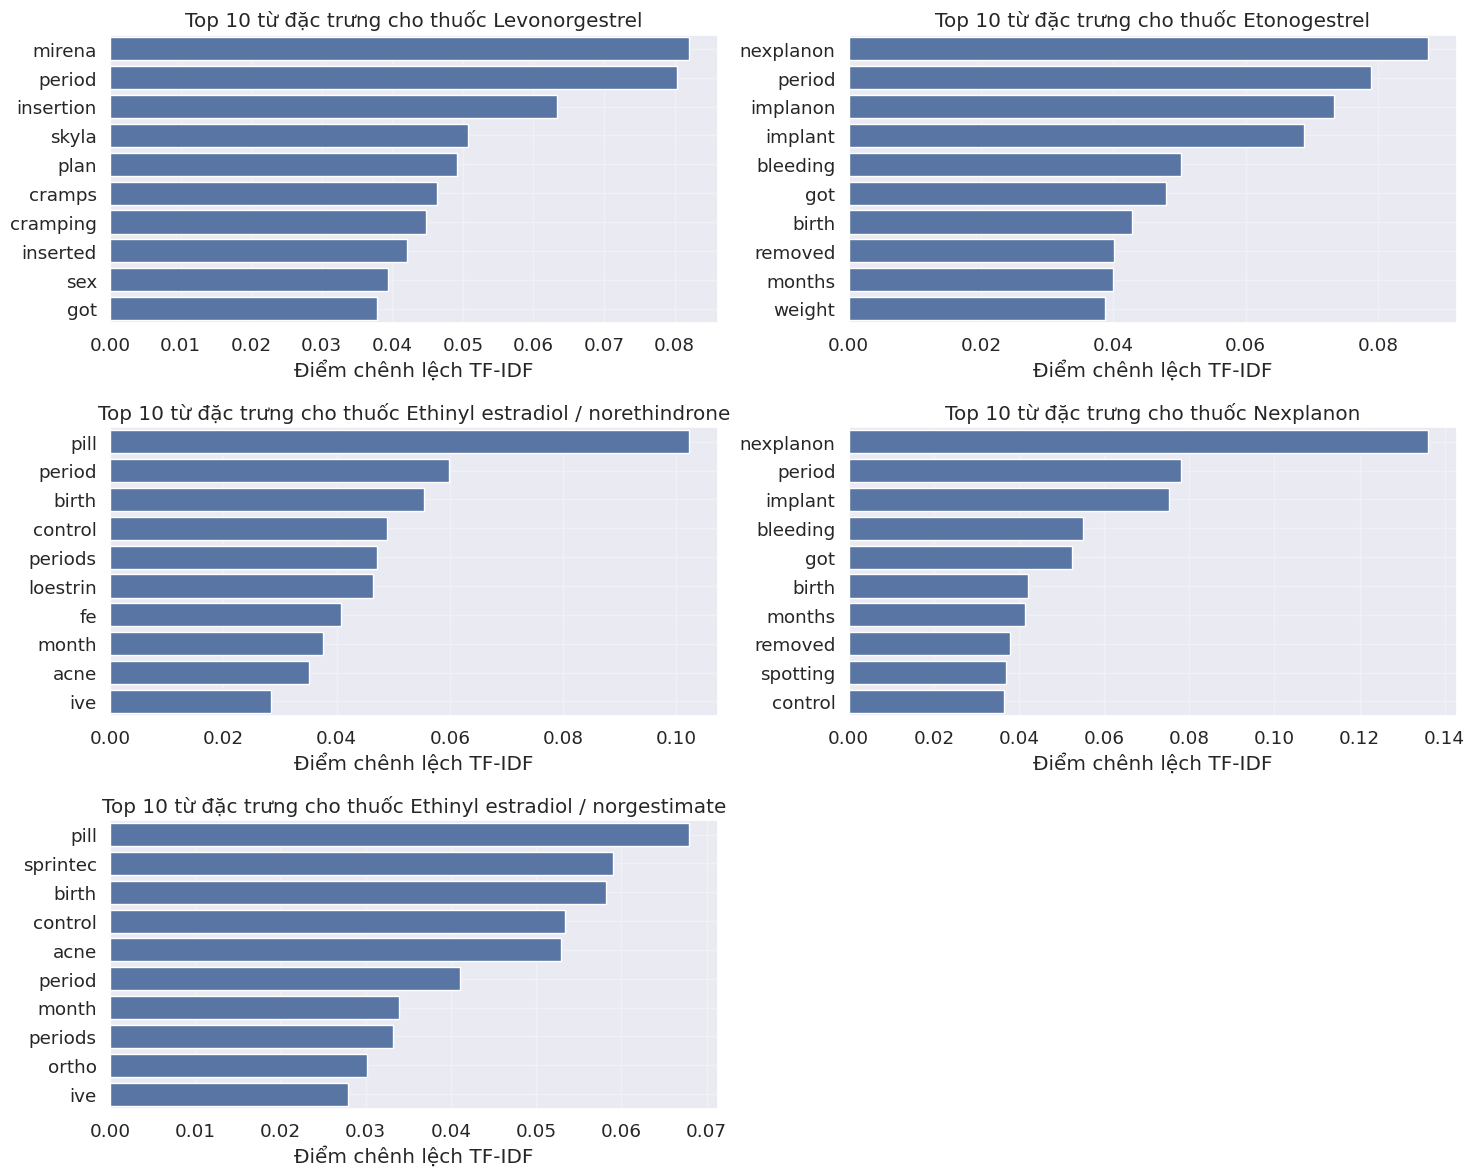

In [ ]:
# Tìm từ đặc trưng cho top 5 thuốc
plt.figure(figsize=(15, 12))
for i, drug in enumerate(top5_drugs, 1):
    distinctive_words = get_top_tfidf_words(drug, 10)
    words, scores = zip(*distinctive_words)

    plt.subplot(3, 2, i)
    sns.barplot(x=list(scores), y=list(words))
    plt.title(f'Top 10 từ đặc trưng cho thuốc {drug}')
    plt.xlabel('Điểm chênh lệch TF-IDF')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1. Levonorgestrel
- Từ "mirena" và "period" có điểm cao nhất, phản ánh rằng Mirena (một loại dụng cụ tử cung chứa Levonorgestrel) rất đặc trưng khi nói về loại thuốc này.
- Các từ liên quan đến việc đặt và triệu chứng cũng nổi bật: "insertion", "skyla", "plan", "cramps", "cramping", "inserted".
- Điều này cho thấy người dùng thường thảo luận về quy trình đặt dụng cụ và tác dụng phụ như chuột rút.

### 2. Etonogestrel
- "Nexplanon" có điểm cao nhất, đây là tên thương mại phổ biến của que cấy tránh thai chứa Etonogestrel.
- "Period", "implanon" (tên thương mại cũ), "implant" cũng đạt điểm cao.
- Từ "bleeding" (chảy máu) có điểm đáng kể, phản ánh một tác dụng phụ phổ biến của phương pháp này.
- "Birth", "removed", "months", "weight" cho thấy người dùng thảo luận về thời gian sử dụng, việc tháo que cấy, và ảnh hưởng đến cân nặng.

### 3. Ethinyl estradiol/norethindrene
- "Pill" có điểm cao nhất, cho thấy đây chủ yếu là thuốc uống.
- Các từ liên quan đến kinh nguyệt như "period", "birth", "control", "periods" khá phổ biến.
- "Loestrin" (một tên thương mại) cũng có điểm cao.
- "Acne" xuất hiện trong top 10, cho thấy tác dụng phụ hoặc tác dụng điều trị mụn của thuốc này được thảo luận nhiều.

### 4. Nexplanon
- "Nexplanon" và "period" lại có điểm cao nhất.
- "Implant", "bleeding", "got", "birth" tiếp theo, phản ánh đây là phương pháp cấy ghép và các chủ đề thảo luận liên quan.
- "Spotting" (ra máu giữa kỳ kinh) xuất hiện trong danh sách, chỉ ra một tác dụng phụ thường gặp.

### 5. Ethinyl estradiol/norgestimate
- "Pill" và "sprintec" (tên thương mại) có điểm cao nhất.
- "Birth", "control", "acne" cũng có điểm cao, cho thấy ngoài tác dụng tránh thai, thuốc còn được dùng để điều trị mụn.
- "Ortho" xuất hiện, có thể liên quan đến tên thương mại Ortho Cyclen/Ortho Tri-Cyclen.

## Nhận xét tổng thể
1. **Hình thức sử dụng**: Có sự phân biệt rõ giữa các phương pháp cấy ghép (Nexplanon, Implanon), dụng cụ tử cung (Mirena, Skyla) và thuốc uống ("pill").

2. **Tác dụng phụ**: "Bleeding", "cramping", "spotting" xuất hiện ở nhiều loại thuốc, phản ánh những lo ngại phổ biến về tác dụng phụ.

3. **Kinh nguyệt**: "Period" xuất hiện trong tất cả các biểu đồ với điểm cao, cho thấy ảnh hưởng đến chu kỳ kinh nguyệt là mối quan tâm chính của người dùng.

4. **Cân bằng lợi ích**: Thuốc Ethinyl estradiol/norgestimate có "acne" với điểm cao, cho thấy ngoài tránh thai, người dùng còn quan tâm đến lợi ích điều trị mụn.

5. **Thời gian sử dụng**: Từ "months", "removed" xuất hiện trong phương pháp cấy ghép, phản ánh sự quan tâm về thời gian hiệu lực và quy trình tháo bỏ.

##  Tóm tắt và Insight về chỉ số Polarity

In [ ]:
# Tóm tắt tổng quan về polarity
print("Tóm tắt thống kê về Polarity:")
print(df_drug['polarity'].describe())

Tóm tắt thống kê về Polarity:
count    110811.000000
mean          0.053052
std           0.202325
min          -1.000000
25%          -0.055000
50%           0.056061
75%           0.170000
max           1.000000
Name: polarity, dtype: float64


In [ ]:
# Phân tích sự khác biệt giữa các nhóm rating
rating_groups = df_drug.groupby('rating_group')['polarity'].agg(['mean', 'median', 'std', 'count'])
print("\nPolarity theo nhóm Rating:")
print(rating_groups)


Polarity theo nhóm Rating:
                     mean    median       std  count
rating_group                                        
Negative (1-4)  -0.050539 -0.031250  0.214030  27103
Neutral (5-7)    0.034516  0.035000  0.185299  16741
Positive (8-10)  0.099612  0.095833  0.184437  66967


In [ ]:
# So sánh polarity giữa các nhóm sentiment và rating
sentiment_rating_stats = df_drug.groupby(['sentiment_category', 'rating_group']).size().unstack()
print("\nPhân phối giữa sentiment và rating:")
print(sentiment_rating_stats)


Phân phối giữa sentiment và rating:
rating_group        Negative (1-4)  Neutral (5-7)  Positive (8-10)
sentiment_category                                                
Extremely Negative             806            139              245
Negative                      8792           3079             7107
Neutral                      11675           7826            27115
Positive                      5602           5522            31198
Extremely Positive             133            157             1277


In [ ]:
# Phân tích các trường hợp không nhất quán (sentiment và rating mâu thuẫn)
inconsistent_cases = df_drug[(df_drug['polarity'] < -0.3) & (df_drug['rating'] > 7) |
                       (df_drug['polarity'] > 0.3) & (df_drug['rating'] < 4)]
print(f"\nSố trường hợp không nhất quán giữa sentiment và rating: {len(inconsistent_cases)}")
print(f"Chiếm {len(inconsistent_cases) / len(df_drug) * 100:.2f}% tổng số review")


Số trường hợp không nhất quán giữa sentiment và rating: 1880
Chiếm 1.70% tổng số review


Khá ít, có thể nói sentiment và rating nhất quán với nhau

In [ ]:
# Phân tích insight về drug và disease dựa trên polarity
drug_disease_polarity = df_drug.groupby(['drugName', 'condition'])['polarity'].mean().reset_index()
drug_disease_count = df_drug.groupby(['drugName', 'condition']).size().reset_index(name='count')
drug_disease_insights = pd.merge(drug_disease_polarity, drug_disease_count, on=['drugName', 'condition'])
drug_disease_insights = drug_disease_insights[drug_disease_insights['count'] >= 10].sort_values('polarity', ascending=False)

In [ ]:
print("\nTop 10 cặp thuốc-bệnh có polarity cao nhất (>=10 reviews):")
drug_disease_insights.head(10)


Top 10 cặp thuốc-bệnh có polarity cao nhất (>=10 reviews):


drugName  \
5284                                            Ritalin   
2720                                          Glipizide   
3242                                        Lamotrigine   
572   Atropine / hyoscyamine / phenobarbital / scopo...   
6102                                          Triazolam   
2859                    Hydrochlorothiazide / valsartan   
3545                                          Lorazepam   
6406                                           Voltaren   
256                                         Almotriptan   
3778                                         Metaxalone   

                           condition  polarity  count  
5284                      narcolepsy  0.260736     11  
2720                diabetes, type 2  0.252075     17  
3242  borderline personality disorde  0.249492     13  
572         irritable bowel syndrome  0.241978     10  
6102                        insomnia  0.238127     16  
2859             high blood pressure  0.229849     10  
3545                 nausea/vomiting  0.218564     11  
6406                  osteoarthritis  0.213306     13  
256                         migraine  0.212828     10  
3778                     ibromyalgia  0.212511     11

In [ ]:
print("\nTop 10 cặp thuốc-bệnh có polarity thấp nhất (>=10 reviews):")
drug_disease_insights.tail(10)


Top 10 cặp thuốc-bệnh có polarity thấp nhất (>=10 reviews):


drugName                    condition  polarity  \
4909                         Previfem                birth control -0.120387   
108                         Acyclovir                   cold sores -0.126854   
885                          Brilinta      acute coronary syndrome -0.129348   
3855                   Metoclopramide              nausea/vomiting -0.134350   
3880                    Metronidazole        clostridial infection -0.137516   
5162                           Reglan              nausea/vomiting -0.141408   
5635                         Sprintec                ovarian cysts -0.144858   
5697  Sulfamethoxazole / trimethoprim            kidney infections -0.153083   
4127                        Naloxegol  opioid-induced constipation -0.165498   
3310                         Levaquin                    pneumonia -0.181356   

      count  
4909     10  
108      16  
885      10  
3855     26  
3880     16  
5162     19  
5635     14  
5697     10  
4127     10  
3310     20

# Phân tích theo mã bệnh nhân (patient_id)

### SỐ LƯỢNG BỆNH NHÂN THEO THÁNG VỚI NĂM

In [ ]:
# Nhóm theo năm: đếm số lượng bệnh nhân duy nhất
patients_per_year = df_drug.groupby('year')['patient_id'].nunique()

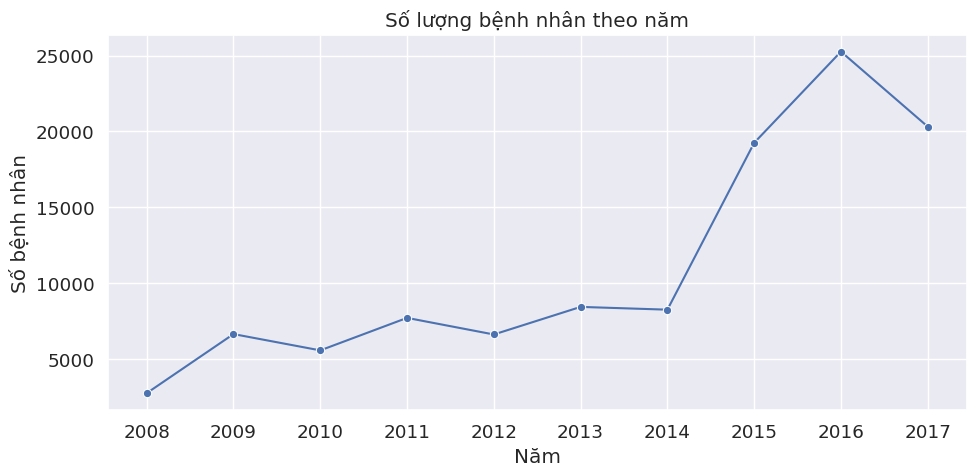

In [ ]:
# Vẽ biểu đồ theo năm
plt.figure(figsize=(10, 5))
sns.lineplot(x=patients_per_year.index, y=patients_per_year.values, marker='o')
plt.title('Số lượng bệnh nhân theo năm')
plt.xlabel('Năm')
plt.ylabel('Số bệnh nhân')

# Hiển thị đầy đủ các năm trên trục x
plt.xticks(ticks=range(patients_per_year.index.min(), patients_per_year.index.max() + 1))

plt.tight_layout()
plt.show()

=> Biểu đồ cho thấy số lượng bệnh nhân tăng nhẹ từ năm 2008 đến 2014, sau đó tăng vọt vào năm 2015–2016 và đạt đỉnh vào năm 2016 với hơn 25,000 người. Tuy nhiên, đến năm 2017, số bệnh nhân đã giảm nhẹ. Sự gia tăng đột biến này cho thấy nhu cầu chăm sóc y tế ngày càng cao. Do đó, cần tăng cường đầu tư cơ sở vật chất và nhân lực y tế để đáp ứng kịp thời. Đồng thời, nên phân tích nguyên nhân của sự biến động để có chiến lược phòng ngừa hiệu quả.

In [ ]:
# Nhóm theo tháng (tính tổng tất cả năm): đếm số lượng bệnh nhân duy nhất
patients_per_month = df_drug.groupby('month')['patient_id'].nunique()

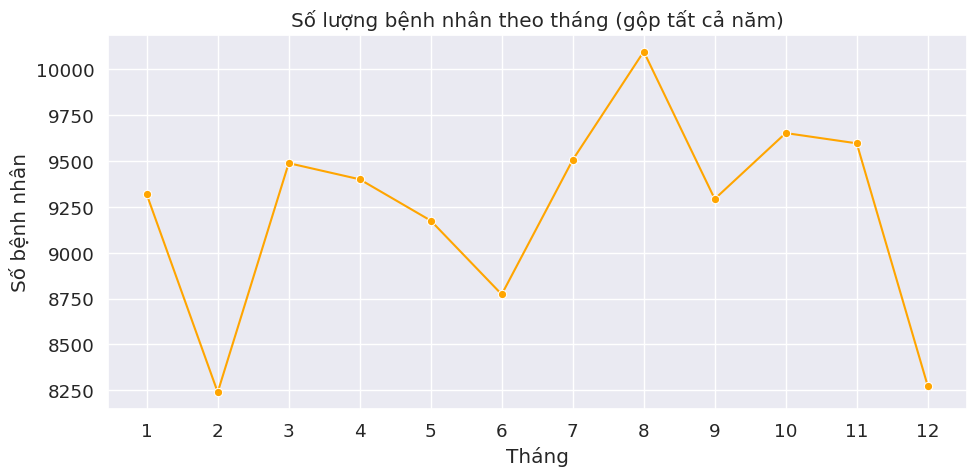

In [ ]:
import numpy as np
# Vẽ biểu đồ số lượng bệnh nhân theo tháng
plt.figure(figsize=(10, 5))
sns.lineplot(x=patients_per_month.index, y=patients_per_month.values, marker='o', color='orange')
plt.title('Số lượng bệnh nhân theo tháng (gộp tất cả năm)')
plt.xlabel('Tháng')
plt.ylabel('Số bệnh nhân')

# Hiển thị đầy đủ các tháng từ 1 đến 12
plt.xticks(ticks=np.arange(1, 13, 1))

plt.tight_layout()
plt.show()

=> Biểu đồ cho thấy số lượng bệnh nhân thay đổi theo từng tháng trong năm, với mức thấp nhất vào tháng 2 và tháng 12. Số ca bệnh tăng dần từ tháng 6, đạt đỉnh vào tháng 8 với hơn 10,000 bệnh nhân, sau đó giảm nhẹ về cuối năm. Điều này cho thấy nhu cầu khám chữa bệnh tăng cao vào mùa hè. Do đó, các cơ sở y tế cần chuẩn bị tốt hơn về nhân lực và thiết bị vào các tháng cao điểm như tháng 7 và 8. Đồng thời, nên có kế hoạch truyền thông, phòng bệnh sớm vào đầu năm để giảm tải hệ thống y tế.

## Top 10 bệnh nhân

In [ ]:
# Lấy 10 review dài nhất (review đơn lẻ)
top10_longest_reviews = df_drug.sort_values(by='review_length', ascending=False).head(10)

# Lấy ra patient_id và độ dài review
top10_bar = top10_longest_reviews[['patient_id', 'review_length']]

# Để cho hiển thị đẹp theo độ dài giảm dần
top10_bar = top10_bar.sort_values(by='review_length', ascending=True)


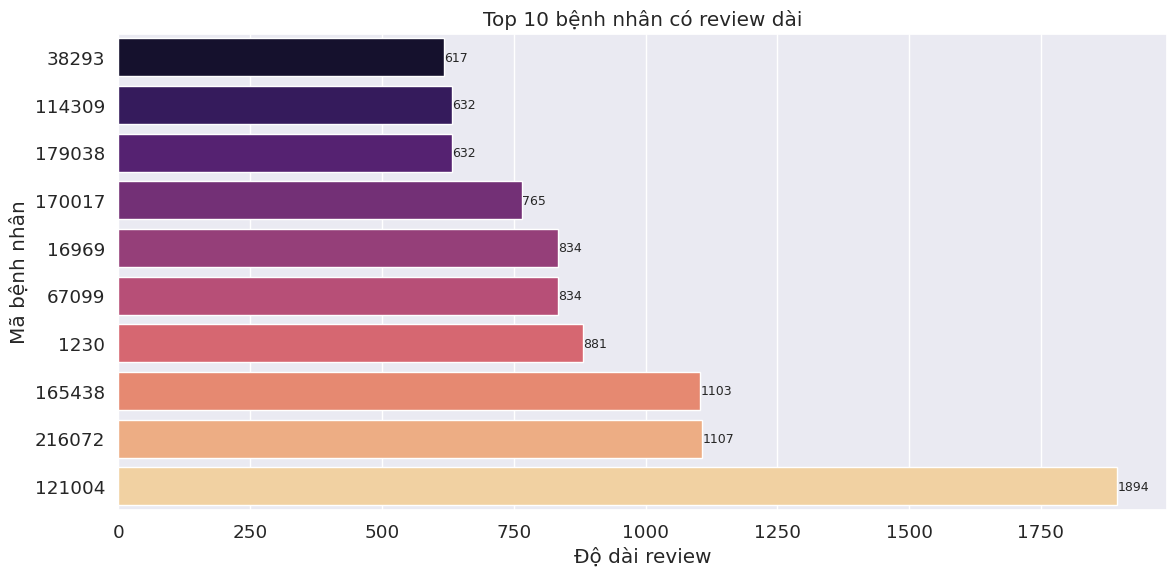

In [ ]:
# Đảm bảo patient_id là string để hiển thị rõ ràng
top10_bar['patient_id'] = top10_bar['patient_id'].astype(str)

# Vẽ lại biểu đồ
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10_bar, x='review_length', y='patient_id', palette='magma')
plt.title('Top 10 bệnh nhân có review dài')
plt.xlabel('Độ dài review')
plt.ylabel('Mã bệnh nhân')

# Thêm label hiển thị giá trị độ dài review
for index, value in enumerate(top10_bar['review_length']):
    plt.text(value + 1, index, str(value), va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Lấy 10 dòng có usefulCount cao nhất
top10_useful = df_drug.sort_values(by='usefulCount', ascending=False).head(10)

# Đảm bảo patient_id là chuỗi để hiển thị đầy đủ
top10_useful['patient_id'] = top10_useful['patient_id'].astype(str)

# Lấy cột cần thiết
top10_useful_plot = top10_useful[['patient_id', 'usefulCount']].sort_values(by='usefulCount', ascending=True)


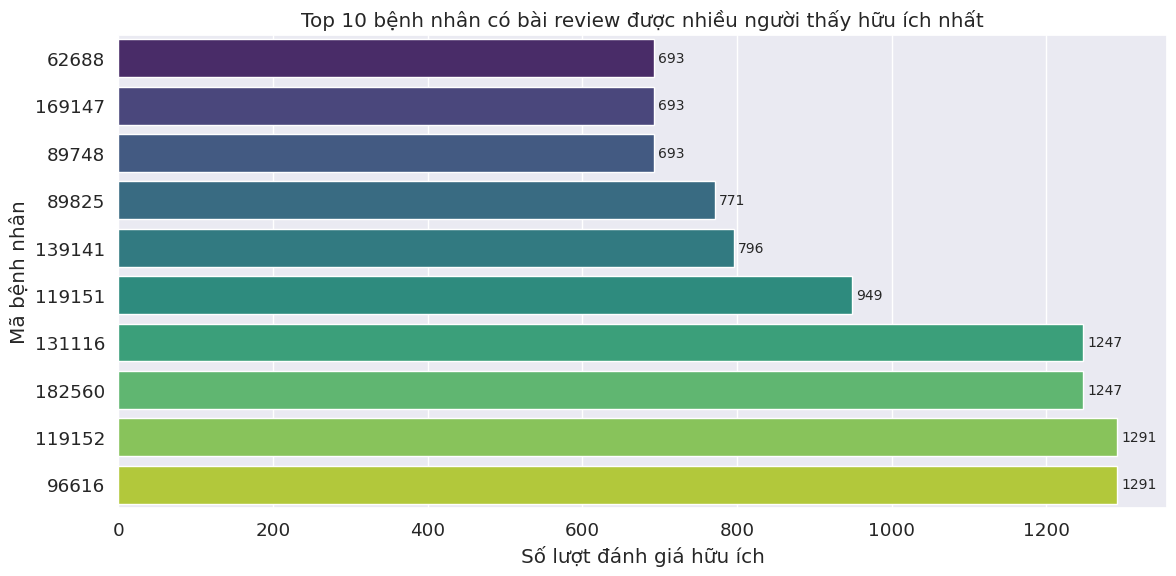

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10_useful_plot, x='usefulCount', y='patient_id', palette='viridis')
plt.title('Top 10 bệnh nhân có bài review được nhiều người thấy hữu ích nhất')
plt.xlabel('Số lượt đánh giá hữu ích')
plt.ylabel('Mã bệnh nhân')

# Thêm label vào mỗi thanh
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', label_type='edge', padding=3, fontsize=10)

plt.tight_layout()
plt.show()


=> Hai biểu đồ "top 10 bệnh nhân review dài" và "top 10 bệnh nhân có review dc nhiều người thấy hữu ích" thể hiện thông tin về độ dài và mức độ hữu ích của các bài review từ bệnh nhân. Biểu đồ thứ nhất cho thấy bệnh nhân có mã 121004 có bài review dài nhất với 1894 ký tự, cho thấy mức độ chia sẻ chi tiết. Trong khi đó, biểu đồ thứ hai cho thấy bệnh nhân 96616 và 119152 có số lượt đánh giá hữu ích cao nhất (1291 lượt), cho thấy bài viết của họ được nhiều người quan tâm và đánh giá cao. Đáng chú ý là không có bệnh nhân nào xuất hiện đồng thời trong cả hai danh sách, điều này cho thấy độ dài review không nhất thiết tương quan với mức độ hữu ích. Do đó, cần khuyến khích bệnh nhân viết các review súc tích, rõ ràng và tập trung vào trải nghiệm để tăng giá trị tham khảo cho người khác.

## Phân tích số lượng bệnh nhân theo solarity

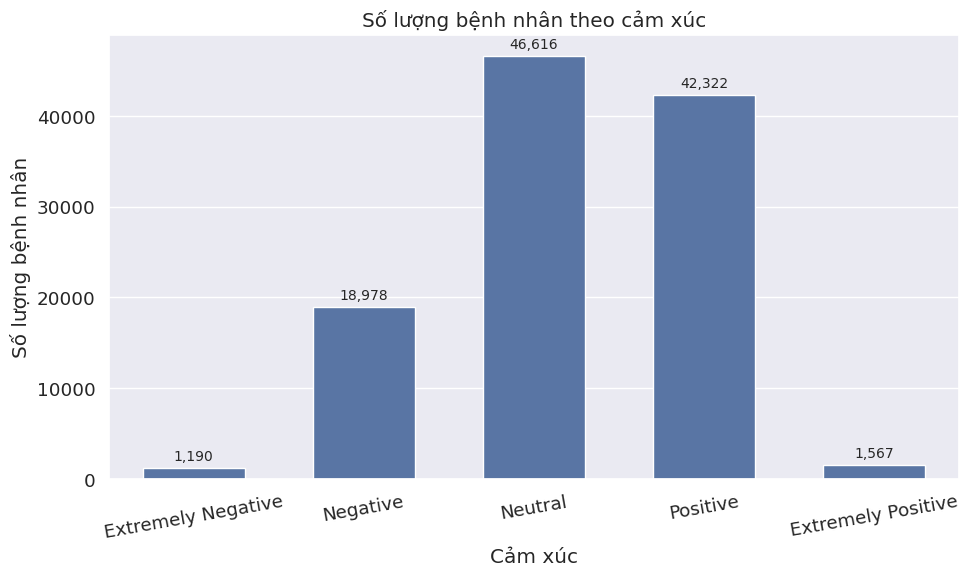

In [ ]:
# Nhóm và đếm số bệnh nhân duy nhất
sentiment_counts = df_drug.groupby('sentiment_category')['patient_id'].nunique().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

# Sắp xếp nếu muốn thứ tự cụ thể (tùy bạn)
order = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
sentiment_counts['sentiment'] = pd.Categorical(sentiment_counts['sentiment'], categories=order, ordered=True)
sentiment_counts = sentiment_counts.sort_values('sentiment')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=sentiment_counts, x='sentiment', y='count', width=0.6)

# Thêm nhãn cột chính xác
for i, row in sentiment_counts.iterrows():
    ax.text(i, row['count'] + 500, f"{row['count']:,}", ha='center', va='bottom', fontsize=10)

# Thêm tiêu đề và nhãn trục
plt.title('Số lượng bệnh nhân theo cảm xúc')
plt.xlabel('Cảm xúc')
plt.ylabel('Số lượng bệnh nhân')
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

=> Biểu đồ cho thấy phần lớn bệnh nhân phản hồi trung tính (46.616) và tích cực (42.322), trong khi phản hồi tiêu cực (“Negative” + “Extremely Negative”) chỉ khoảng 20.168, và “Extremely Positive” rất ít (1.567). Để nâng cao trải nghiệm, nên khảo sát sâu nhóm phản hồi tiêu cực nhằm tìm nguyên nhân bất mãn và cải thiện dịch vụ. Đồng thời, khuyến khích nhóm cực kỳ tích cực chia sẻ đánh giá thông qua chương trình ưu đãi và cân bằng dữ liệu khi phân tích để tránh bias.

## Phân tích số lượng bệnh nhân theo rating

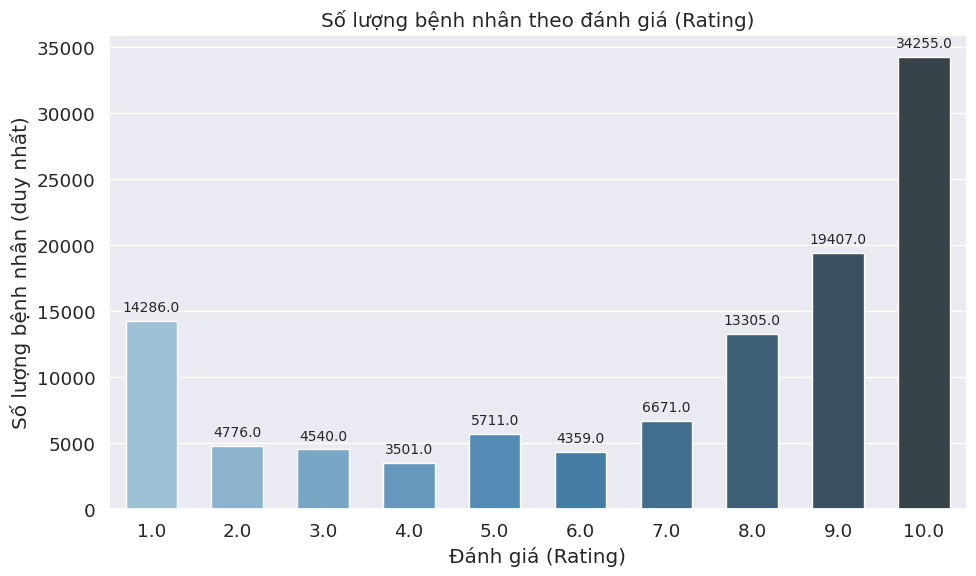

In [ ]:
# Nhóm theo rating và đếm số bệnh nhân duy nhất
rating_counts = df_drug.groupby('rating')['patient_id'].nunique().reset_index()
rating_counts.columns = ['rating', 'count']

# Sắp xếp theo rating tăng dần
rating_counts = rating_counts.sort_values('rating')

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=rating_counts, x='rating', y='count', width=0.6, palette='Blues_d')

# Thêm nhãn trên cột
for i, row in rating_counts.iterrows():
    ax.text(i, row['count'] + 500, f"{row['count']}", ha='center', va='bottom', fontsize=10)

# Giao diện và chú thích
plt.title('Số lượng bệnh nhân theo đánh giá (Rating)')
plt.xlabel('Đánh giá (Rating)')
plt.ylabel('Số lượng bệnh nhân (duy nhất)')
plt.tight_layout()
plt.show()


=> Biểu đồ cho thấy bệnh nhân chủ yếu cho điểm cao, đặc biệt là 10 (34.255) và 9 (19.407), trong khi điểm thấp như 1 chỉ có 14.286 và các mức 2–6 rất ít. Điều này cho thấy tổng thể hài lòng cao nhưng cũng có lượng nhỏ phản ánh chưa tốt. Đề xuất: tập trung phân tích chi tiết lý do cho điểm trung bình và thấp (1–4) để khắc phục điểm yếu, đồng thời khai thác phản hồi tích cực để truyền thông và nâng cao uy tín.

# Phân tích theo condition (tình trạng bệnh)

## phân tích số lượng theo năm, tháng

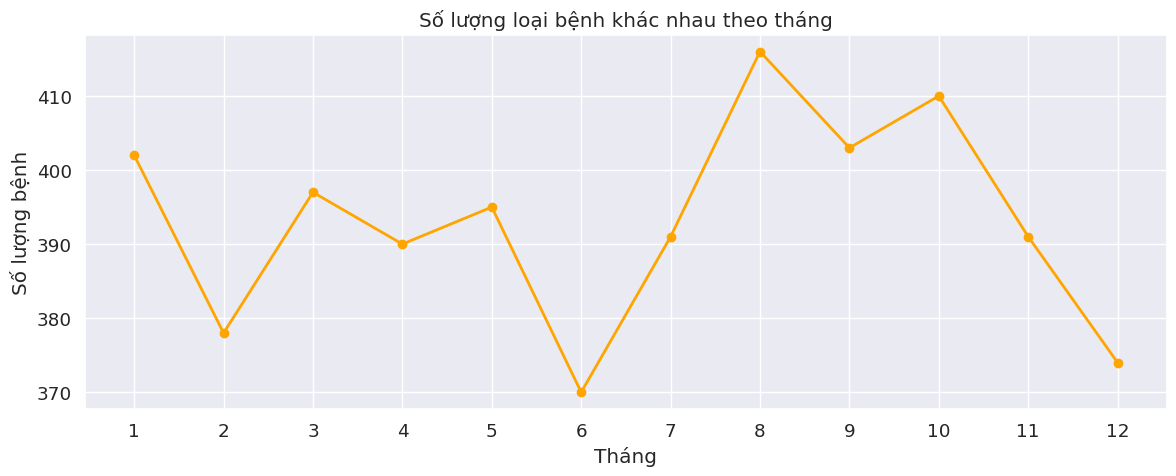

In [ ]:
# Đếm số lượng condition KHÁC NHAU theo tháng
monthly_unique_condition = df_drug.groupby('month')['condition'].nunique().reset_index(name='unique_conditions')

# Vẽ line chart
plt.figure(figsize=(12, 5))
plt.plot(monthly_unique_condition['month'],
         monthly_unique_condition['unique_conditions'],
         color='orange', marker='o', linewidth=2)

plt.title('Số lượng loại bệnh khác nhau theo tháng')
plt.xlabel('Tháng')
plt.ylabel('Số lượng bệnh')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


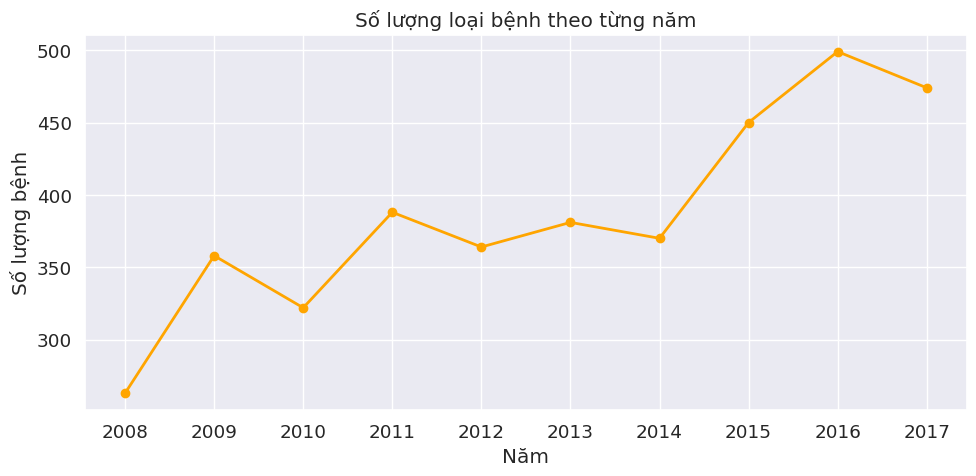

In [ ]:
yearly_unique_condition = df_drug.groupby('year')['condition'].nunique().reset_index(name='unique_condition_count')

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(yearly_unique_condition['year'],
         yearly_unique_condition['unique_condition_count'],
         color='orange', marker='o', linewidth=2)

plt.title('Số lượng loại bệnh theo từng năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng bệnh')
plt.xticks(yearly_unique_condition['year'])
plt.grid(True)
plt.tight_layout()
plt.show()

- Biểu đồ tháng cho thấy số loại bệnh dao động nhẹ quanh mức 370–416, giảm thấp nhất vào tháng 6 (370) và đạt đỉnh vào tháng 8 (416). Điều này có thể phản ánh mùa hè – đầu thu làm gia tăng khám bệnh đa dạng (dị ứng, nhiễm trùng đường hô hấp…)
- Biểu đồ năm cho thấy xu hướng tăng rõ rệt: từ khoảng 265 loại bệnh năm 2008 lên gần 500 năm 2016, sau đó hơi giảm 2017 (475). Điều này phản ánh mở rộng chuyên môn, thêm danh mục chẩn đoán và/hoặc gia tăng bệnh nhân.

- Đề xuất chung:

_ Với dao động theo tháng, cần chủ động chuẩn bị nguồn lực (nhân sự, thuốc men) cao điểm mùa hè – đầu thu.

_Với tăng trưởng dài hạn, xem xét cập nhật danh mục chẩn đoán, đào tạo nhân viên cho các bệnh mới, và tối ưu quy trình quản lý hồ sơ để đáp ứng khối lượng ngày càng đa dạng.

## Lấy top 10

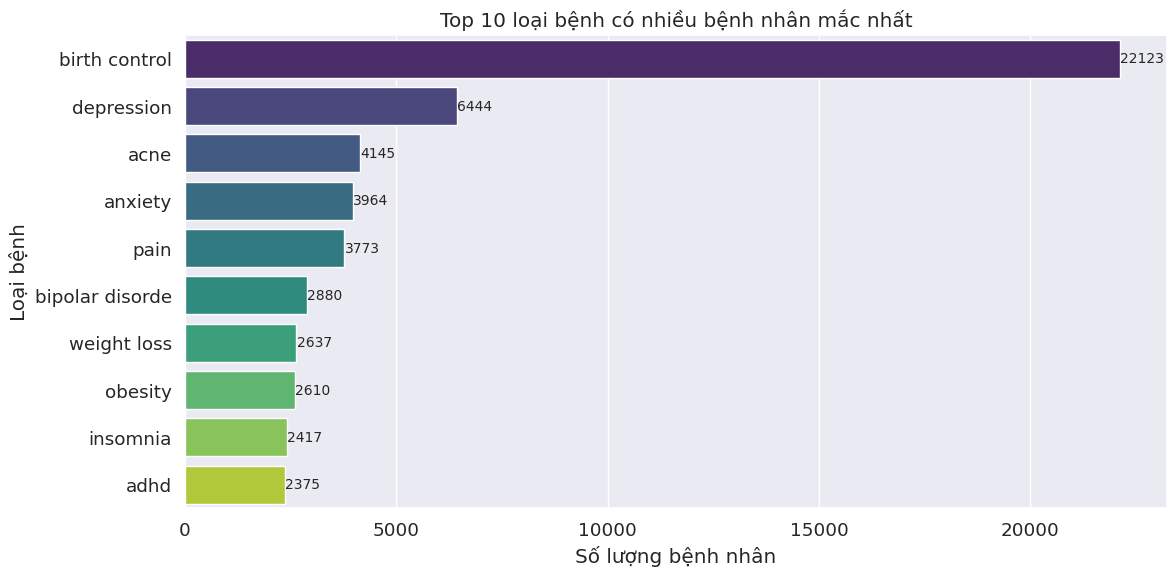

In [ ]:
# Lấy lại top 10 loại bệnh có nhiều bệnh nhân nhất
top_conditions = df_drug.groupby('condition')['patient_id'].nunique().reset_index(name='patient_count')
top_conditions = top_conditions.sort_values(by='patient_count', ascending=False).head(10)

# Vẽ biểu đồ cột ngang
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_conditions, x='patient_count', y='condition', palette='viridis')

# Thêm nhãn số trên mỗi thanh
for i in ax.patches:
    ax.text(i.get_width() + 1, i.get_y() + i.get_height() / 2,
            f'{int(i.get_width())}', va='center', fontsize=10)

plt.title('Top 10 loại bệnh có nhiều bệnh nhân mắc nhất')
plt.xlabel('Số lượng bệnh nhân')
plt.ylabel('Loại bệnh')
plt.tight_layout()
plt.show()

=> Biểu đồ cho thấy “birth control” chiếm áp đảo với 22.123 bệnh nhân, gấp hơn 3 lần “depression” (6.444), đồng thời các rối loạn tâm thần cũng xuất hiện nhiều trong top 10, cho thấy nhu cầu rất cao về dịch vụ tránh thai và chăm sóc sức khỏe tâm thần. Do đó, nên mở rộng tư vấn tránh thai đa kênh (trực tiếp và online) kết hợp hệ thống nhắc nhở tuân thủ qua SMS/email, đồng thời phát triển gói chăm sóc tâm thần với khảo sát, tư vấn chuyên sâu để đáp ứng hiệu quả nhu cầu bệnh nhân.

In [ ]:
# 1. Nhóm theo condition -> đếm số loại thuốc duy nhất
condition_drug_counts = df_drug.groupby('condition')['drugName'].nunique().reset_index()
condition_drug_counts = condition_drug_counts[condition_drug_counts['drugName'] >= 4]

# 2. Lấy Top 10 condition có nhiều loại thuốc nhất
top10_conditions = condition_drug_counts.sort_values('drugName', ascending=False).head(10)['condition']

# 3. Lọc dữ liệu gốc để lấy thông tin drugName theo 10 condition này
top10_df = df_drug[df_drug['condition'].isin(top10_conditions)][['condition', 'drugName']].drop_duplicates()

# 4. (Optional) Đếm lại số thuốc cho từng bệnh để hiển thị
drug_counts = top10_df.groupby('condition')['drugName'].nunique().reset_index().rename(columns={'drugName': 'Số loại thuốc'})


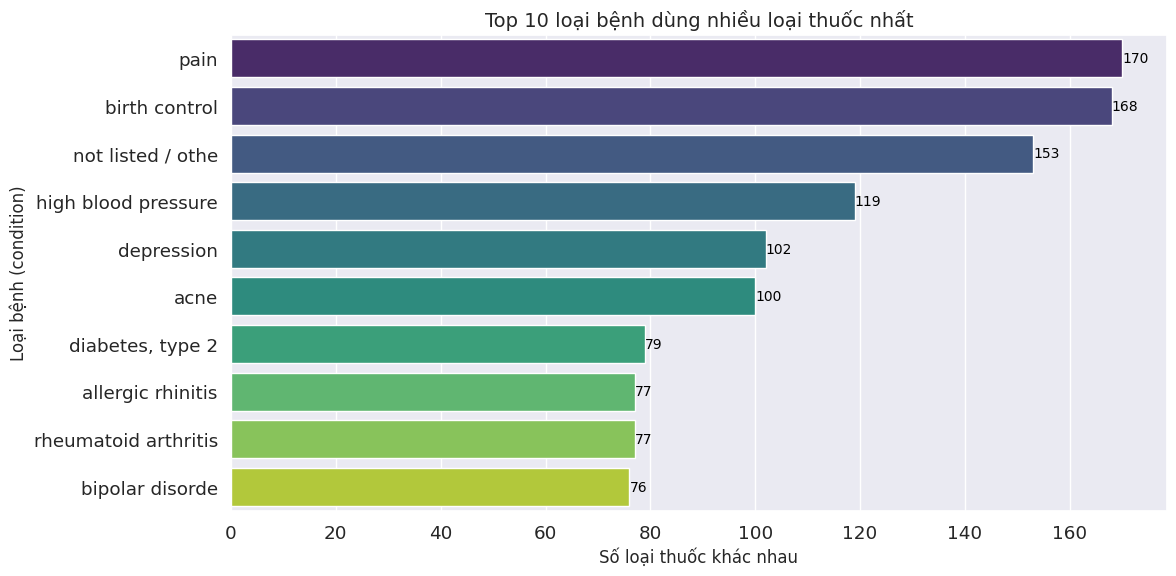

In [ ]:
# Vẽ barplot số loại thuốc theo từng bệnh
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=drug_counts.sort_values('Số loại thuốc', ascending=False),
                 x='Số loại thuốc', y='condition', palette='viridis')

# Title và labels
plt.title('Top 10 loại bệnh dùng nhiều loại thuốc nhất', fontsize=14)
plt.xlabel('Số loại thuốc khác nhau', fontsize=12)
plt.ylabel('Loại bệnh (condition)', fontsize=12)

# Thêm label nằm ngang trên đỉnh mỗi cột
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}',
                (width, p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=10, color='black')

# Tùy chỉnh layout cho đẹp
plt.tight_layout()
plt.show()



=> Dựa trên biểu đồ, có thể thấy rằng đau là loại bệnh có số lượng loại thuốc khác nhau được sử dụng nhiều nhất (170 loại), theo sau là kiểm soát sinh sản (168 loại) và không được liệt kê/khác (153 loại). Các bệnh như huyết áp cao, trầm cảm, mụn trứng cá, tiểu đường tuýp 2, viêm mũi dị ứng, viêm khớp dạng thấp và rối loạn lưỡng cực có số lượng loại thuốc sử dụng ít hơn đáng kể, dao động từ 76 đến 119 loại.

## Phân tích tỷ lệ hữu ích so với tổng review

In [ ]:
# Tính tổng số review theo condition
agg_df = df_drug.groupby('condition').agg(
    review_count=('review', 'count'),
    useful_count=('usefulCount', 'sum')
).reset_index()

# Sắp xếp và lấy top 10 condition có nhiều review nhất
agg_df = agg_df.sort_values(by='review_count', ascending=False).head(10)

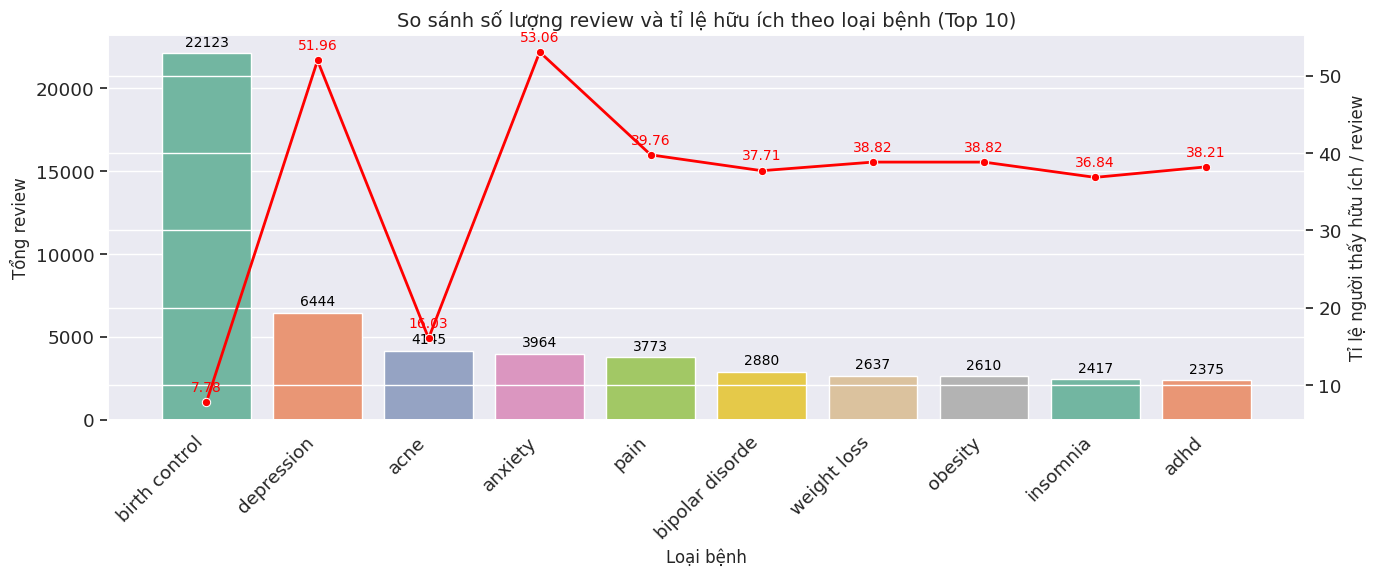

In [ ]:
# Tính tỉ lệ hữu ích
agg_df['tỉ lệ hữu ích'] = agg_df['useful_count'] / agg_df['review_count']

fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Vẽ cột: Tổng review ---
bar = sns.barplot(data=agg_df, x='condition', y='review_count', palette='Set2', ax=ax1)
ax1.set_ylabel('Tổng review', fontsize=12)
ax1.set_xlabel('Loại bệnh', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Label số review trên cột
for p in bar.patches:
    ax1.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=10, color='black',
                 xytext=(0, 3), textcoords='offset points')

# --- Trục phụ: Đường tỉ lệ hữu ích ---
ax2 = ax1.twinx()
line = sns.lineplot(data=agg_df, x='condition', y='tỉ lệ hữu ích',
                    color='red', marker='o', linewidth=2, ax=ax2)
ax2.set_ylabel('Tỉ lệ người thấy hữu ích / review', fontsize=12)

# Label tỉ lệ hữu ích trên mỗi điểm
for x, y in zip(range(len(agg_df)), agg_df['tỉ lệ hữu ích']):
    ax2.annotate(f'{y:.2f}',
                 (x, y),
                 textcoords="offset points", xytext=(0, 8),
                 ha='center', fontsize=10, color='red')

# --- Title + Layout ---
plt.title('So sánh số lượng review và tỉ lệ hữu ích theo loại bệnh (Top 10)', fontsize=14)
plt.tight_layout()
plt.show()



=> Có thể thấy rằng kiểm soát sinh sản có tổng số lượng review cao nhất (22123), nhưng tỷ lệ người thấy hữu ích lại tương đối thấp (11.93%). Ngược lại, lo âu có tổng số lượng review thấp hơn nhiều (3964) nhưng lại có tỷ lệ hữu ích cao nhất (53.06%).
- Số lượng review không phải là thước đo duy nhất cho sự hữu ích. "Kiểm soát sinh sản" có lượng review lớn nhất nhưng tỷ lệ hữu ích lại thấp, cho thấy nhiều review có thể chung chung hoặc không đi sâu vào thông tin người dùng cần.
- Ngược lại, "lo âu" có ít review hơn nhưng tỷ lệ hữu ích cao, gợi ý rằng các review tập trung và chia sẻ kinh nghiệm cá nhân sâu sắc được đánh giá cao hơn. Điều này nhấn mạnh rằng chất lượng và tính phù hợp của thông tin quan trọng hơn số lượng, đặc biệt trong lĩnh vực sức khỏe, nơi người dùng tìm kiếm những kinh nghiệm và lời khuyên thực tế.